In [1]:
# === CONFIGURACIÓN INICIAL Y BIBLIOTECAS BÁSICAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import re
import time
import warnings
import os
import gc
import pickle
from functools import partial
warnings.filterwarnings('ignore')

# Para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

print("=== INSTALACIÓN DE DEPENDENCIAS ===")
# Función para instalar paquetes si no están disponibles
def install_if_missing(package_name, import_name=None, version=None):
    if import_name is None:
        import_name = package_name

    install_cmd = f"pip install {package_name}"
    if version:
        install_cmd += f"=={version}"

    try:
        __import__(import_name)
        print(f"✓ {package_name} ya está instalado")
    except ImportError:
        print(f"Instalando {package_name}...")
        import sys
        from subprocess import check_call
        check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"✓ {package_name} instalado correctamente")

# Instalación de paquetes necesarios
install_if_missing("tqdm")
install_if_missing("joblib")
install_if_missing("nltk")
install_if_missing("scikit-learn")
install_if_missing("xgboost")
install_if_missing("lightgbm")
install_if_missing("spacy")
install_if_missing("textstat")

# Intentar instalar catboost con manejo de errores
try:
    install_if_missing("catboost")
    import catboost as cb
    has_catboost = True
except Exception:
    print("⚠️ No se pudo instalar catboost. El modelo será excluido.")
    has_catboost = False

# Instalación de bibliotecas opcionales (para interpretabilidad)
try:
    install_if_missing("shap")
    has_shap = True
except Exception:
    print("⚠️ No se pudo instalar shap. La interpretabilidad SHAP será omitida.")
    has_shap = False

try:
    install_if_missing("lime")
    has_lime = True
except Exception:
    print("⚠️ No se pudo instalar lime. La interpretabilidad LIME será omitida.")
    has_lime = False

try:
    install_if_missing("transformers")
    install_if_missing("torch")
    from transformers import pipeline
    import torch
    has_transformers = True
    # Verificar disponibilidad de GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")
except Exception:
    print("⚠️ No se pudo instalar transformers/torch. Las características de embeddings serán omitidas.")
    has_transformers = False

# Importar bibliotecas ahora que están instaladas
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import nltk
from nltk.corpus import stopwords
from concurrent.futures import ThreadPoolExecutor
from collections import Counter

# Descarga de recursos necesarios para NLTK
print("\nDescargando recursos NLTK...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar spaCy
try:
    import spacy
    try:
        nlp = spacy.load("es_core_news_md")
        print("✓ Modelo spaCy español (medio) cargado correctamente")
    except:
        print("Instalando modelo español para spaCy...")
        import sys
        from subprocess import check_call
        check_call([sys.executable, "-m", "spacy", "download", "es_core_news_md"])
        nlp = spacy.load("es_core_news_md")
except Exception as e:
    print(f"⚠️ Error al cargar spaCy: {e}")
    print("Usando un procesamiento de texto más básico")
    has_spacy = False
else:
    has_spacy = True

# Importar métricas y herramientas de procesamiento de sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_curve, auc, roc_auc_score, precision_recall_curve,
                           average_precision_score, f1_score, precision_score, recall_score,
                           matthews_corrcoef)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

# Modelos tradicionales
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier, VotingClassifier)
import xgboost as xgb
import lightgbm as lgb


=== INSTALACIÓN DE DEPENDENCIAS ===
✓ tqdm ya está instalado
✓ joblib ya está instalado
✓ nltk ya está instalado
Instalando scikit-learn...
✓ scikit-learn instalado correctamente
✓ xgboost ya está instalado
✓ lightgbm ya está instalado
✓ spacy ya está instalado
Instalando textstat...
✓ textstat instalado correctamente
Instalando catboost...
✓ catboost instalado correctamente
✓ shap ya está instalado
Instalando lime...
✓ lime instalado correctamente
✓ transformers ya está instalado
✓ torch ya está instalado
Usando dispositivo: cuda

Descargando recursos NLTK...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Instalando modelo español para spaCy...



=== CARGA DE DATOS ===
Dataset cargado con 4349 registros y 6 columnas.
Tiempo de carga: 0.14 segundos.
Columna 'split' eliminada del dataset.
Uso de memoria: 11.36 MB

Valores nulos por columna:
title     1500
source       2
dtype: int64

Distribución de clases:


,Counts,Percentage
label,,
Verdadera,2847,65.463325
Falsa,1502,34.536675



Primeras filas del dataset:


,label,content,title,source,dataset
0,Falsa,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",El Ruinaversal,posadas
1,Falsa,"La palabra ""haiga"", aceptada por la RAE La Rea...","La palabra ""haiga"", aceptada por la RAE",Hay noticia,posadas
2,Falsa,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,El Ruinaversal,posadas



=== PREPROCESAMIENTO DE ETIQUETAS ===
Etiquetas únicas encontradas: ['Falsa' 'Verdadera']

Distribución después del mapeo:


,Counts,Percentage
label_num,,
1,2847,65.463325
0,1502,34.536675



=== ANÁLISIS EXPLORATORIO DE DATOS ===
Estadísticas de longitud:

Title_length:


,title_length
count,4349.000000
mean,44.583812
std,36.529577
min,0.000000
25%,0.000000
50%,54.000000
75%,72.000000
max,166.000000



Title_word_count:


,title_word_count
count,4349.000000
mean,7.236606
std,6.033972
min,0.000000
25%,0.000000
50%,8.000000
75%,12.000000
max,28.000000



Content_length:


,content_length
count,4349.000000
mean,1498.430674
std,1787.648474
min,95.000000
25%,294.000000
50%,993.000000
75%,2054.000000
max,32584.000000



Content_word_count:


,content_word_count
count,4349.000000
mean,238.717176
std,295.756814
min,8.000000
25%,37.000000
50%,159.000000
75%,332.000000
max,5647.000000


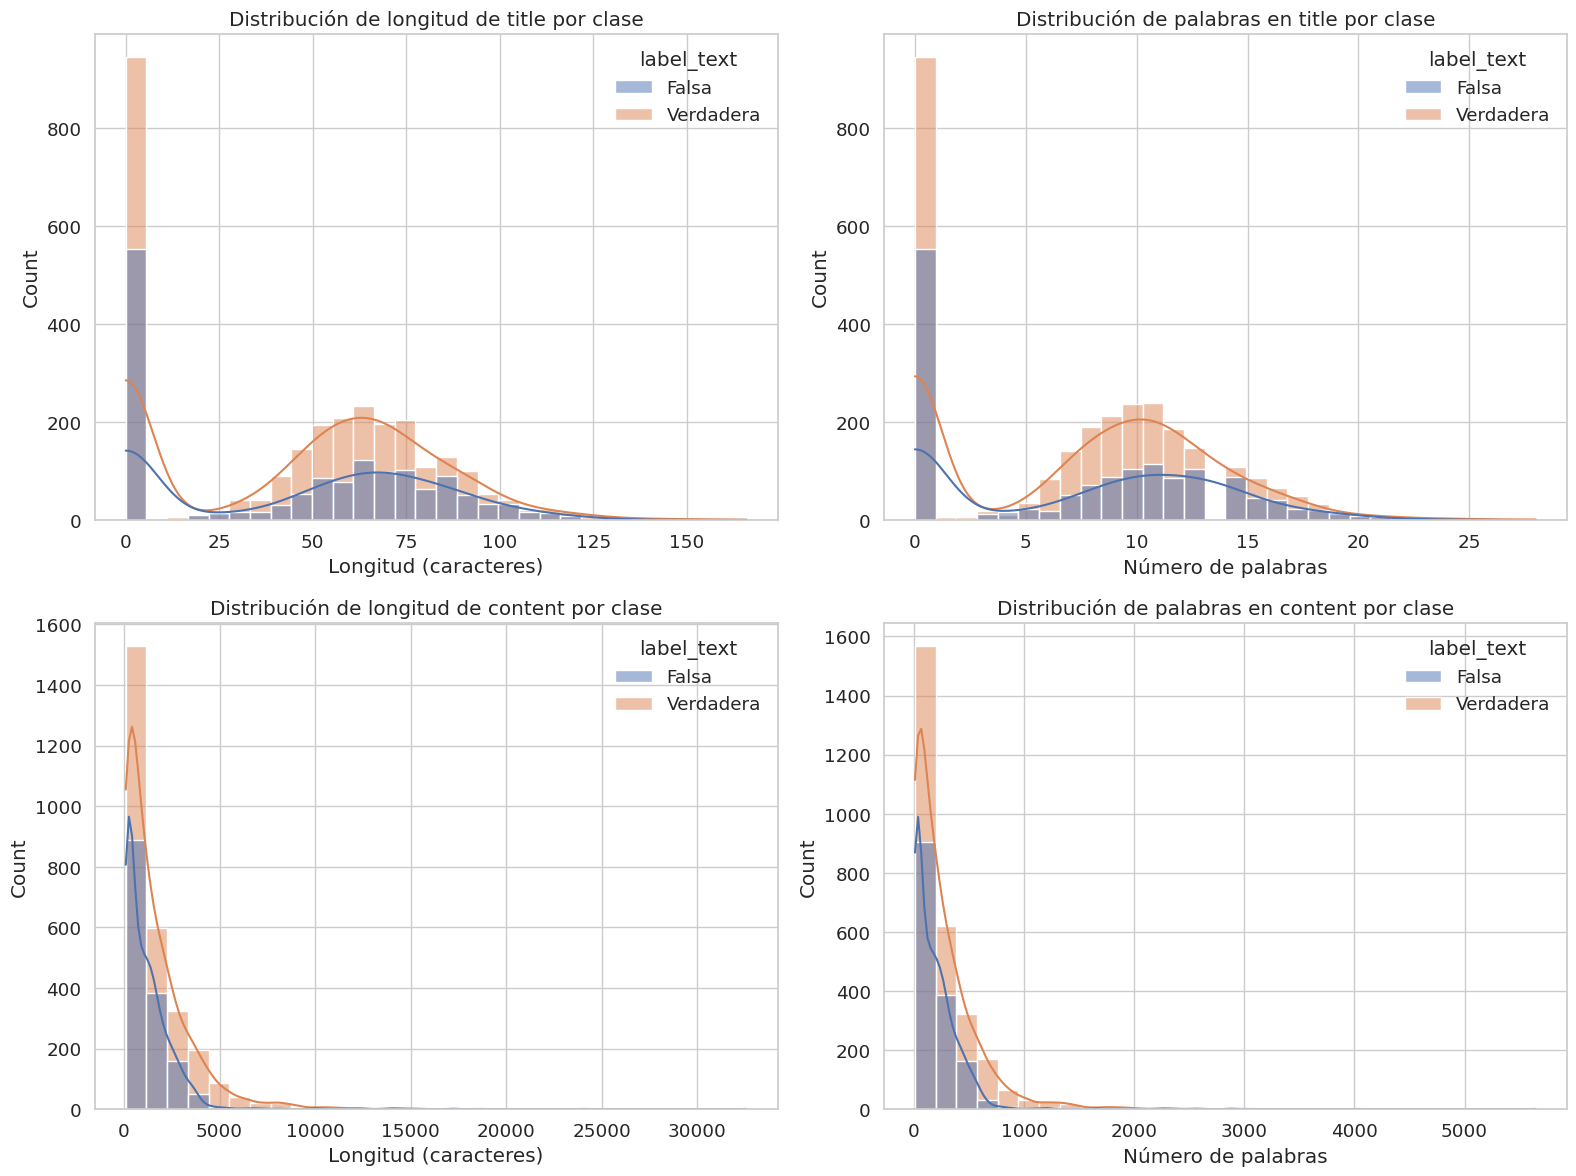


Palabras más frecuentes por clase:

Palabras más comunes en title - Noticias VERDADERAS:


,Palabra,Frecuencia
0,nan,946
1,covid,97
2,number,67
3,amlo,66
4,pide,60
5,gobierno,60
6,bukele,60
7,arena,58
8,fmln,53
9,dice,47



Palabras más comunes en title - Noticias FALSAS:


,Palabra,Frecuencia
0,nan,554
1,number,72
2,amlo,61
3,ley,46
4,méxico,43
5,gobierno,30
6,pide,25
7,diputados,25
8,tras,24
9,dice,22


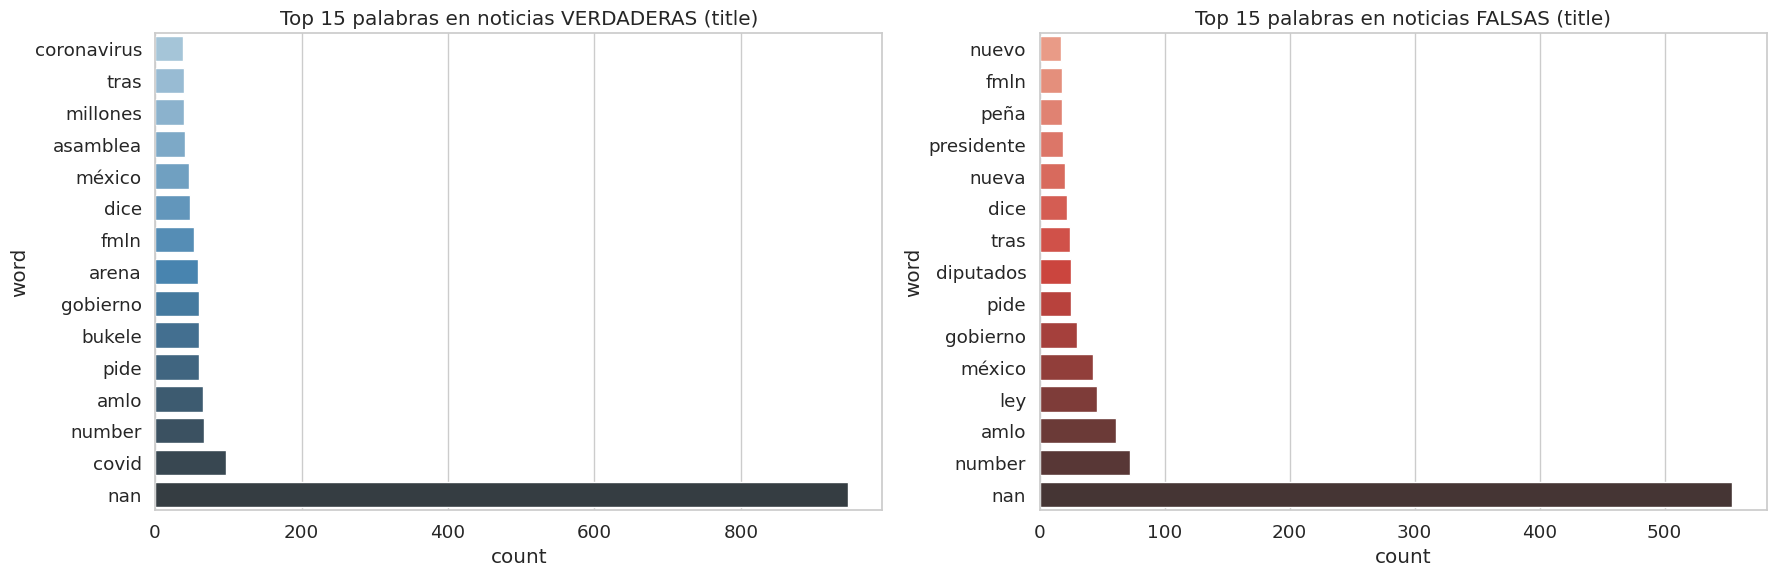


Palabras más comunes en content - Noticias VERDADERAS:


,Palabra,Frecuencia
0,number,3898
1,content,2075
2,source,2070
3,prediction,2070
4,presidente,1596
5,true,1576
6,https,1517
7,gobierno,1390
8,dijo,1274
9,país,1195



Palabras más comunes en content - Noticias FALSAS:


,Palabra,Frecuencia
0,number,1178
1,source,1022
2,prediction,1022
3,content,1022
4,fake,958
5,https,866
6,ley,573
7,méxico,552
8,presidente,531
9,ser,468


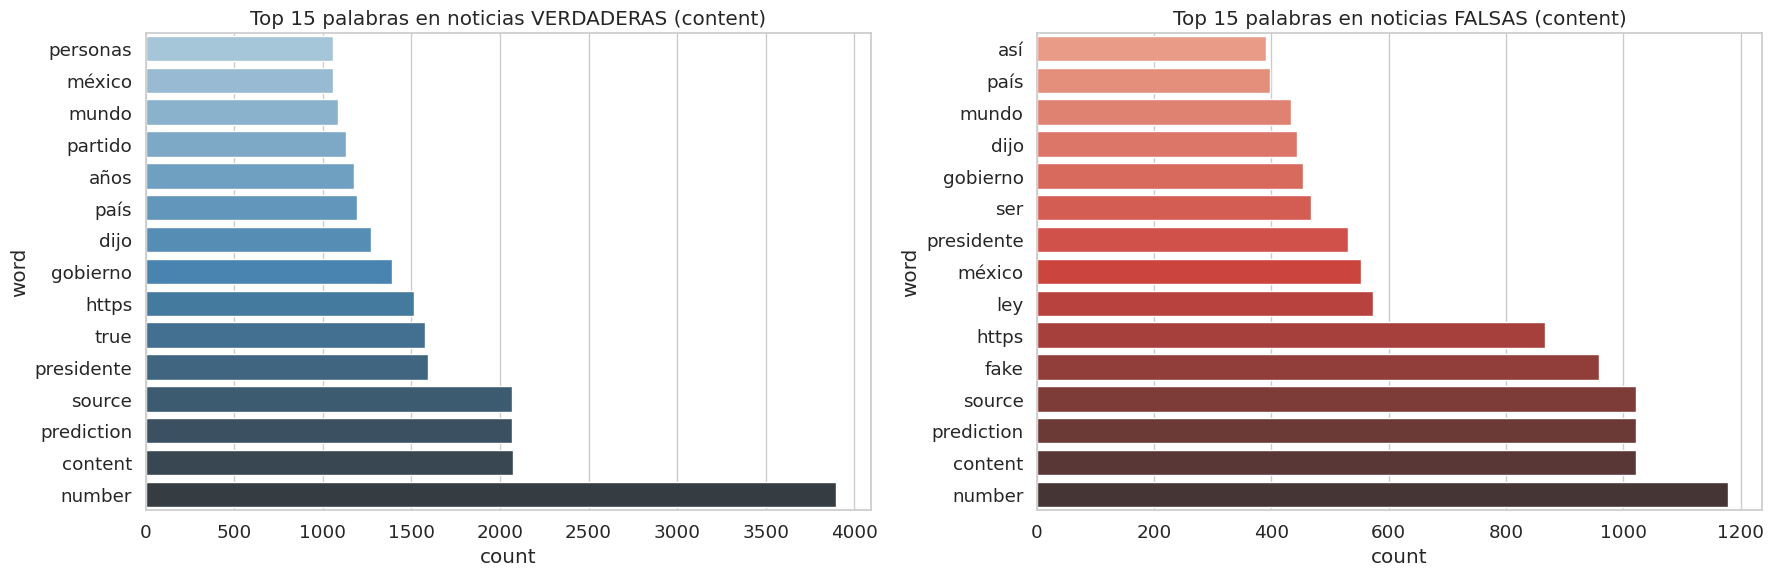


=== PREPROCESAMIENTO AVANZADO DE TEXTO ===

=== MANEJO DE VALORES NULOS ===
Valores nulos por columna antes de limpieza:
  title: 1500 (34.49%)
  source: 2 (0.05%)
Reemplazando 1500 valores nulos en 'title' con string vacío
Reemplazando 2 valores nulos en 'source' con el valor más común: 'El Mundo'
Todos los valores nulos han sido manejados correctamente.

=== DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA ===
Dataset dividido en:
  • Entrenamiento: 3044 registros (70.0%)
  • Validación: 435 registros (10.0%)
  • Prueba: 870 registros (20.0%)

Distribución de clases:

Entrenamiento:
  • Falsa: 1992 registros (34.56%)
  • Verdadera: 1052 registros (65.44%)

Validación:
  • Falsa: 285 registros (34.48%)
  • Verdadera: 150 registros (65.52%)

Prueba:
  • Falsa: 570 registros (34.48%)
  • Verdadera: 300 registros (65.52%)

=== PREPROCESAMIENTO DE TEXTO EN CONJUNTO DE ENTRENAMIENTO ===
Procesando 3044 registros de entrenamiento...
Procesando columna 'title'...


Procesando textos en lotes:   0%|          | 0/4 [00:00<?, ?it/s]

Longitud promedio de 'title' original: 45.1 caracteres
Longitud promedio de 'title' procesado: 32.2 caracteres

Ejemplos de preprocesamiento:

Original 1: Más del 70 % de los salvadoreños teme a la letalidad de coronavirus y su impacto económico...
Procesado 1: num salvadoreno temer letalidad coronaviru impacto economico...

Original 2: ...
Procesado 2: ...

Original 3: ...
Procesado 3: ...
Procesando columna 'content'...


Procesando textos en lotes:   0%|          | 0/4 [00:00<?, ?it/s]

Longitud promedio de 'content' original: 1497.8 caracteres
Longitud promedio de 'content' procesado: 925.7 caracteres

Ejemplos de preprocesamiento:

Original 1: Source:El Mundo

 Prediction:Fake

 Content:
El 87 % considera que es el momento de prohibir salir de casa en un largo tiempo ante los temores del avance de la propagación del COVID-19; mientras el 66...
Procesado 1: source mundo prediction fake content NUM momento prohibir salir casa tiempo temor avance propagacion covid NUM NUM prudente suspender transporte publico evitar aglomeración foto archivo dem reciente e...

Original 2: Source:SinEmbargoMX

 Prediction:True

 Content:Con un sueldo de un millón 567 mil 400 pesos durante el 2020 el Presidente López Obrador mostró su declaración con el ingreso neto y detalló que su únic...
Procesado 2: source sinembargomx prediction true content sueldo millon num mil NUM pesos NUM presidente lopez obrador mostro declaracion ingreso neto detallo unico fuente ingreso salario funcionario p

Procesando entrenamiento:   0%|          | 0/3044 [00:00<?, ?it/s]


Características lingüísticas extraídas:
  • title_length: int64
  • title_word_count: int64
  • content_length: int64
  • content_word_count: int64
  • title_exclamation_count: int64
  • title_question_count: int64
  • content_exclamation_count: int64
  • content_question_count: int64
  • title_sensational_count: int64
  • content_sensational_count: int64
  • title_number_count: int64
  • content_number_count: int64
  • title_uppercase_ratio: float64
  • title_content_ratio: float64
  • title_excl_quest_density: float64
  • title_sensational_density: float64
  • content_sensational_density: float64
  • title_avg_word_length: float64
  • title_content_word_mismatch: float64
  • has_round_numbers: int64
Total de características extraídas: 20

Extrayendo características para validación...


Procesando validación:   0%|          | 0/435 [00:00<?, ?it/s]


Extrayendo características para prueba...


Procesando prueba:   0%|          | 0/870 [00:00<?, ?it/s]


=== PROCESAMIENTO DE CONJUNTOS DE VALIDACIÓN Y PRUEBA ===
Procesando 435 registros de validación...
Procesando columna 'title'...


Procesando textos en lotes:   0%|          | 0/1 [00:00<?, ?it/s]

Longitud promedio de 'title' original: 42.1 caracteres
Longitud promedio de 'title' procesado: 29.3 caracteres

Ejemplos de preprocesamiento:

Original 1: La DGT obligará a los copilotos a pasar también el test de alcoholemia...
Procesado 1: dgt obligar copiloto pasar test alcoholemia...

Original 2: Saltillo: todo por un like, niños viralizan sus travesuras en redes sociales...
Procesado 2: saltillo like ninos viralizar travesura red social...

Original 3: Sorpresiva sesión privada de Zúñiga con diputados...
Procesado 3: sorpresivo sesion privado zuniga diputados...
Procesando columna 'content'...


Procesando textos en lotes:   0%|          | 0/1 [00:00<?, ?it/s]

Longitud promedio de 'content' original: 1476.8 caracteres
Longitud promedio de 'content' procesado: 910.6 caracteres

Ejemplos de preprocesamiento:

Original 1: La DGT obligará a los copilotos a pasar también el test de alcoholemia Una nueva medida propuesta por la Dirección General de Tráfico (DGT) obligará también a los pilotos y acompañantes de los conduct...
Procesado 1: dgt obligar copiloto pasar test alcoholemiar medida propuesto direccion general trafico dgt obligara piloto acompanant conductor soplar test alcoholemia dgt piloto bebido vehiculo persón libre alcohol...

Original 2: Source:La Vanguardia

 Prediction:Fake

 Content:Menores se graban haciendo “travesuras” a vecinos y transeúntes en colonias de Saltillo, aunque algunas rayan en las ofensas o agresionesAprobación, pe...
Procesado 2: source vanguardia prediction fake content menor grar travesura vecino transeunt colonia saltillo rayar ofensa agresionesaprobacion pertenencia reconocimiento busquedar adolescente traves 

Procesando textos en lotes:   0%|          | 0/1 [00:00<?, ?it/s]

Longitud promedio de 'title' original: 44.0 caracteres
Longitud promedio de 'title' procesado: 31.4 caracteres

Ejemplos de preprocesamiento:

Original 1: ...
Procesado 1: ...

Original 2: ...
Procesado 2: ...

Original 3: ...
Procesado 3: ...
Procesando columna 'content'...


Procesando textos en lotes:   0%|          | 0/1 [00:00<?, ?it/s]

Longitud promedio de 'content' original: 1511.4 caracteres
Longitud promedio de 'content' procesado: 933.3 caracteres

Ejemplos de preprocesamiento:

Original 1: Source:SinEmbargoMX

 Prediction:Fake

 Content:#Sofá Con un espectáculo lleno de humor y una crítica voraz a la escena política actual, Las Reinas Chulas se unen una vez más para presentar Lo que dig...
Procesado 1: source sinembargomx prediction fake content sofa espectaculo lleno humor criticar voraz escena politico actual reina chula unir presentar decir deditir musical obra cabaret asegurar publico pasar rato...

Original 2: Source:lopezdoriga

 Prediction:Fake

 Content:Hugo Torres, uno de los guerrilleros sandinistas más audaces en la lucha contra la dictadura de Anastasio Somoza, murió como un “preso político”, según l...
Procesado 2: source lopezdoriga prediction fake content hugo torre guerrillero sandinista audaz lucha dictaduro anastasio somoza murio preso politico organismo humanitario traidor patria dictador dani

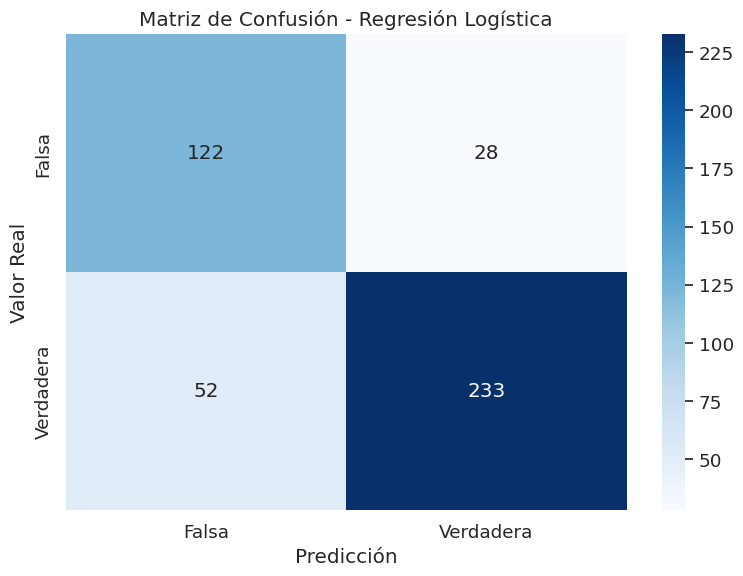

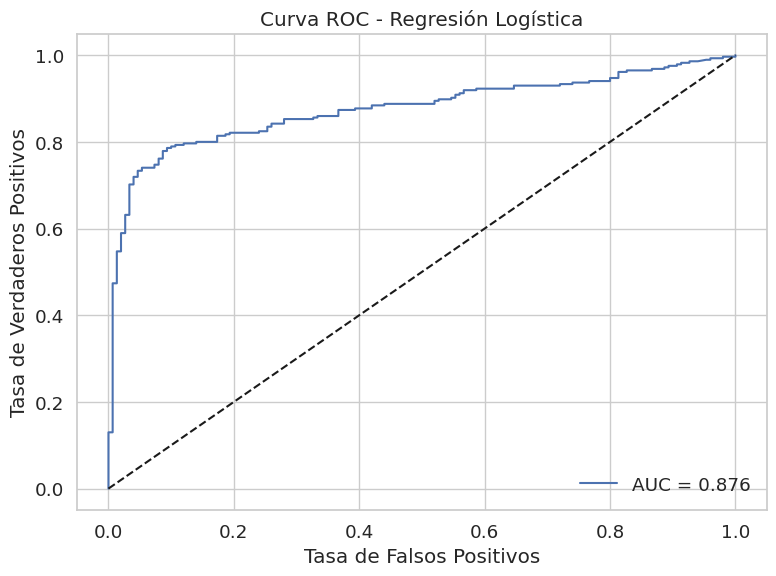


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.70      0.81      0.75       150
   Verdadera       0.89      0.82      0.85       285

    accuracy                           0.82       435
   macro avg       0.80      0.82      0.80       435
weighted avg       0.83      0.82      0.82       435


Entrenando modelo: SVM Lineal

=== Resultados para SVM Lineal ===
Precisión (Accuracy): 0.8023
Precisión (Precision): 0.8541
Exhaustividad (Recall): 0.8421
F1-Score: 0.8481
Tiempo de entrenamiento: 0.46 segundos


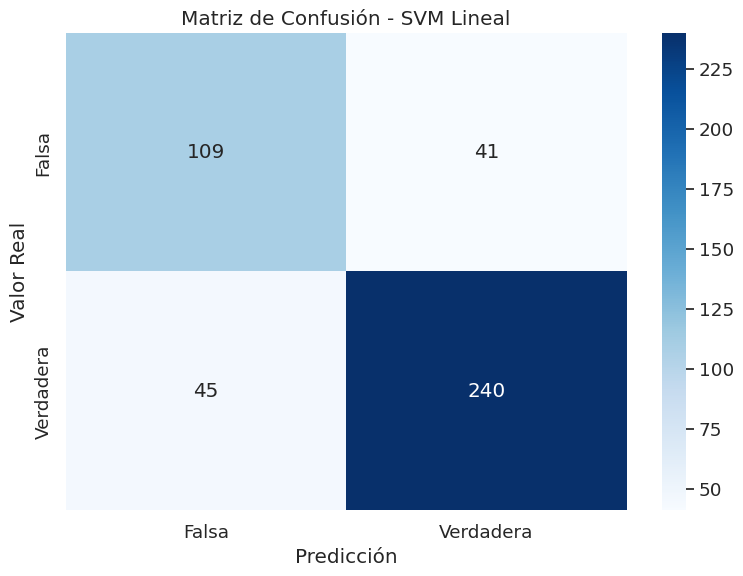


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.71      0.73      0.72       150
   Verdadera       0.85      0.84      0.85       285

    accuracy                           0.80       435
   macro avg       0.78      0.78      0.78       435
weighted avg       0.80      0.80      0.80       435


Entrenando modelo: Random Forest

=== Resultados para Random Forest ===
Precisión (Accuracy): 0.8322
Precisión (Precision): 0.8897
Exhaustividad (Recall): 0.8491
F1-Score: 0.8689
AUC-ROC: 0.8910
Tiempo de entrenamiento: 6.03 segundos


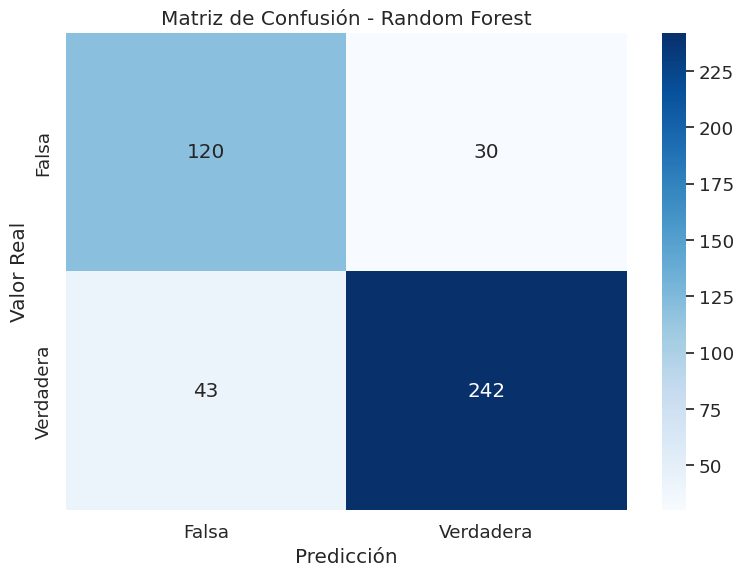

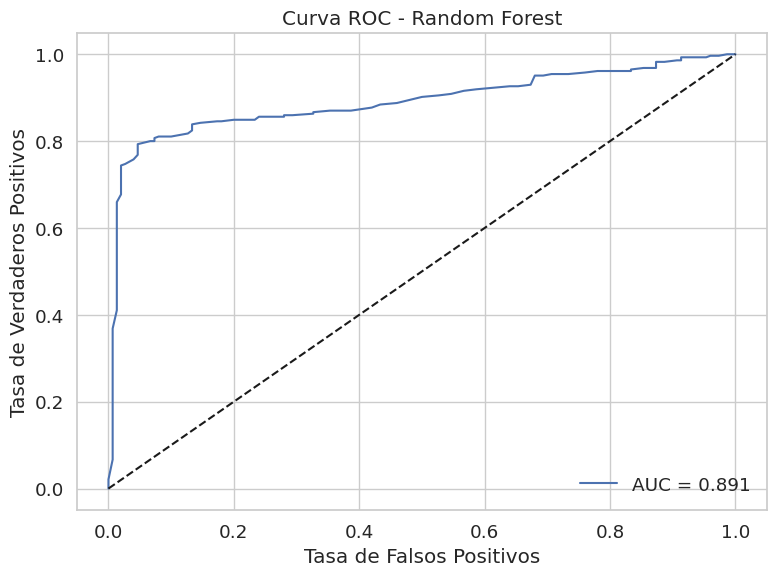


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.74      0.80      0.77       150
   Verdadera       0.89      0.85      0.87       285

    accuracy                           0.83       435
   macro avg       0.81      0.82      0.82       435
weighted avg       0.84      0.83      0.83       435


Entrenando modelo: Gradient Boosting

=== Resultados para Gradient Boosting ===
Precisión (Accuracy): 0.8046
Precisión (Precision): 0.8497
Exhaustividad (Recall): 0.8526
F1-Score: 0.8511
AUC-ROC: 0.8966
Tiempo de entrenamiento: 102.74 segundos


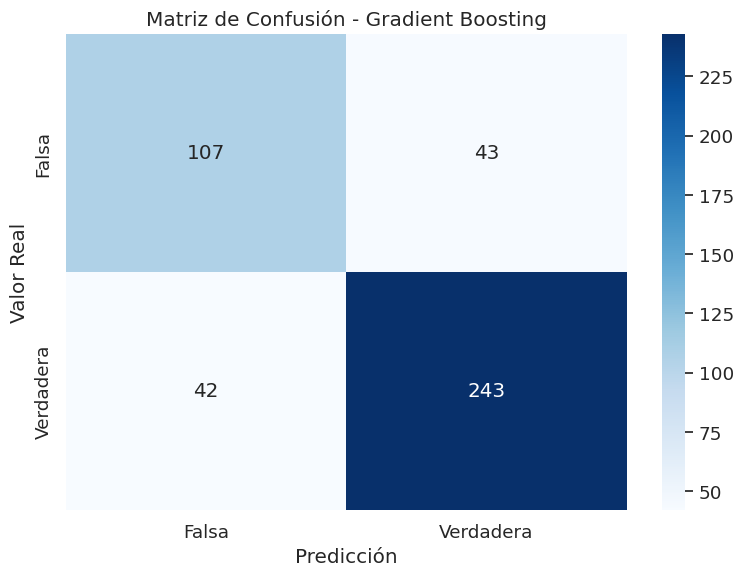

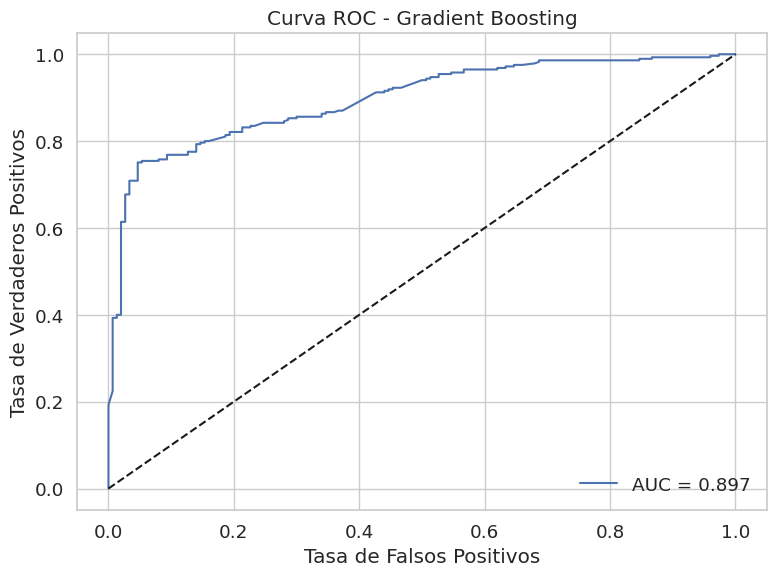


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.72      0.71      0.72       150
   Verdadera       0.85      0.85      0.85       285

    accuracy                           0.80       435
   macro avg       0.78      0.78      0.78       435
weighted avg       0.80      0.80      0.80       435


Entrenando modelo: XGBoost

=== Resultados para XGBoost ===
Precisión (Accuracy): 0.8414
Precisión (Precision): 0.8885
Exhaustividad (Recall): 0.8667
F1-Score: 0.8774
AUC-ROC: 0.9132
Tiempo de entrenamiento: 24.02 segundos


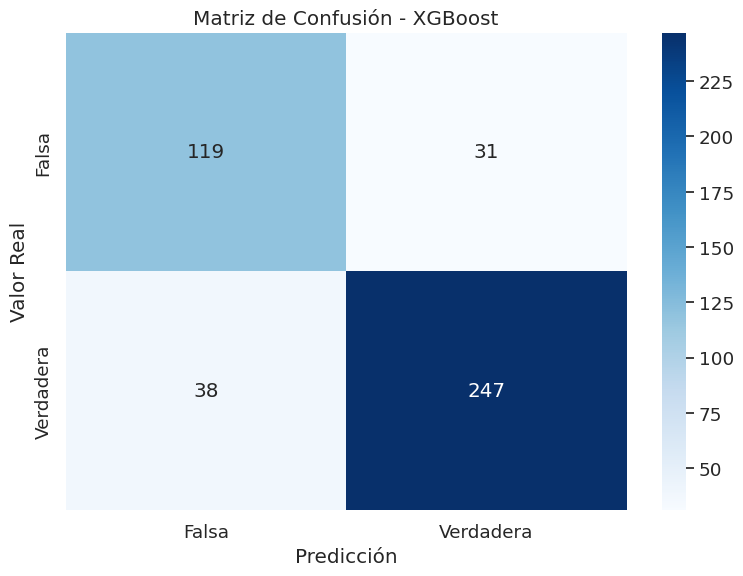

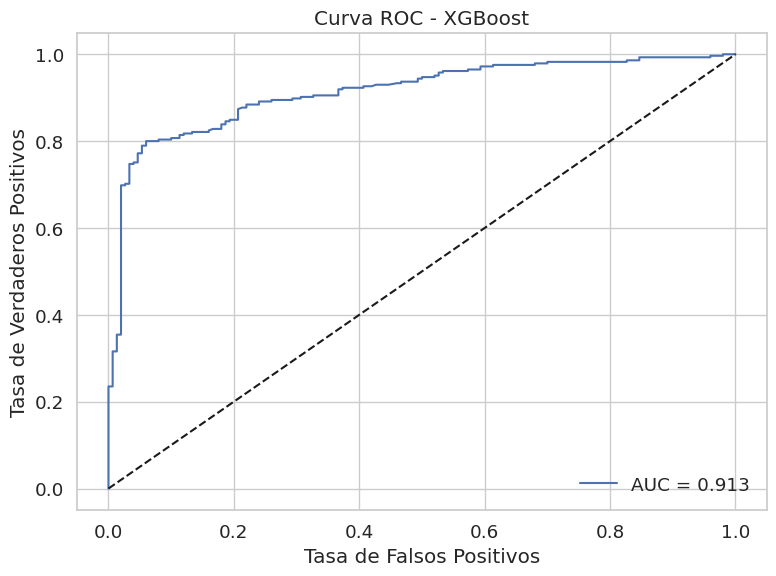


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.76      0.79      0.78       150
   Verdadera       0.89      0.87      0.88       285

    accuracy                           0.84       435
   macro avg       0.82      0.83      0.83       435
weighted avg       0.84      0.84      0.84       435


Entrenando modelo: LightGBM
[LightGBM] [Info] Number of positive: 1992, number of negative: 1052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66361
[LightGBM] [Info] Number of data points in the train set: 3044, number of used features: 2782
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

=== Resultados para LightGBM ===
Precisión (Accu

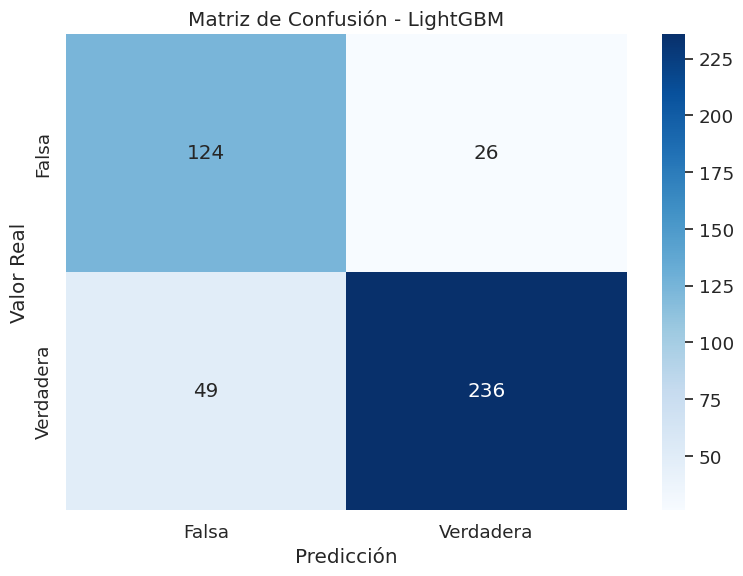

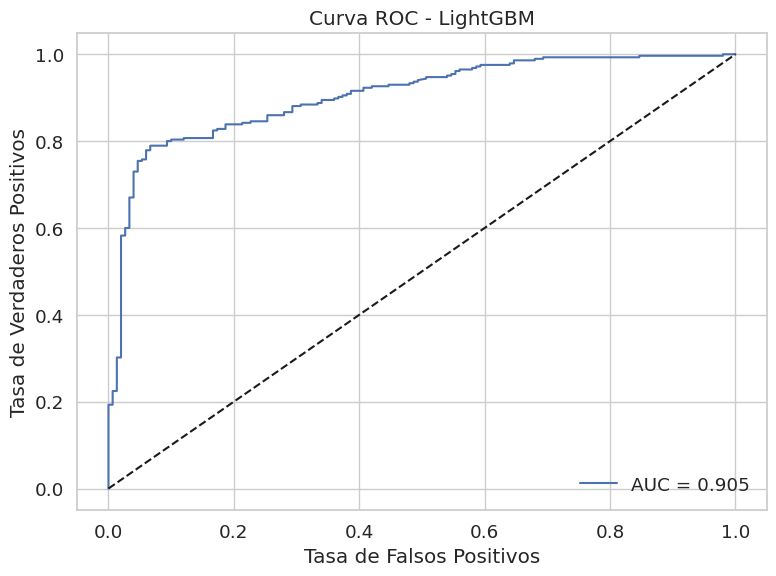


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.72      0.83      0.77       150
   Verdadera       0.90      0.83      0.86       285

    accuracy                           0.83       435
   macro avg       0.81      0.83      0.82       435
weighted avg       0.84      0.83      0.83       435


Entrenando modelo: CatBoost

=== Resultados para CatBoost ===
Precisión (Accuracy): 0.8092
Precisión (Precision): 0.8435
Exhaustividad (Recall): 0.8702
F1-Score: 0.8566
AUC-ROC: 0.8935
Tiempo de entrenamiento: 40.46 segundos


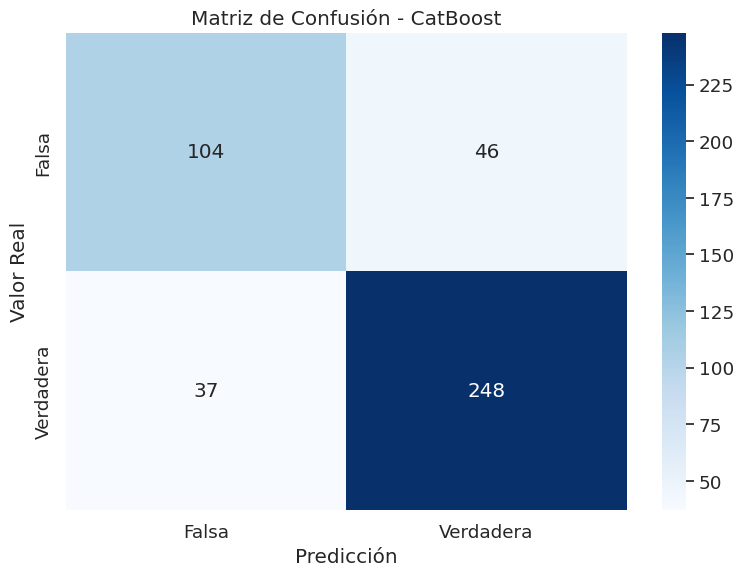

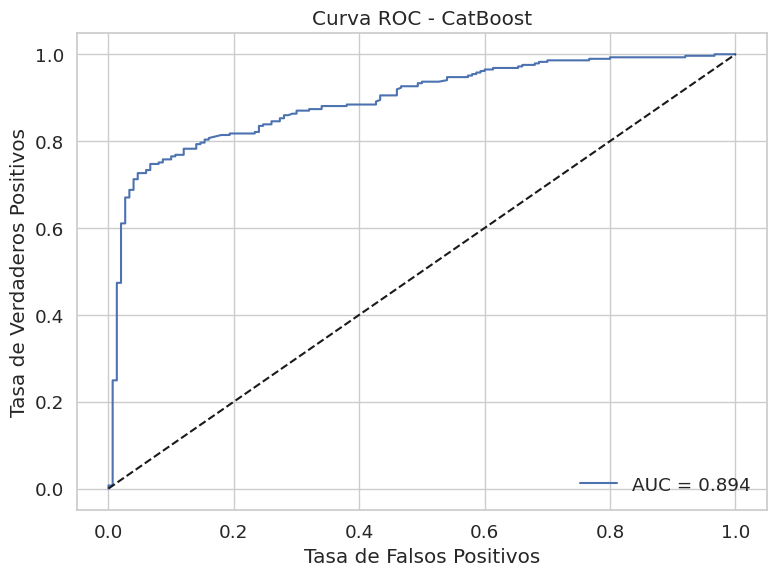


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.74      0.69      0.71       150
   Verdadera       0.84      0.87      0.86       285

    accuracy                           0.81       435
   macro avg       0.79      0.78      0.79       435
weighted avg       0.81      0.81      0.81       435


=== COMPARACIÓN DE MODELOS ===


,model_name,accuracy,precision,recall,f1_score,auc,training_time
4,XGBoost,0.841379,0.888489,0.866667,0.877442,0.913205,24.021276
2,Random Forest,0.832184,0.889706,0.849123,0.868941,0.890994,6.025394
5,LightGBM,0.827586,0.900763,0.828070,0.862888,0.905287,3.619530
6,CatBoost,0.809195,0.843537,0.870175,0.856649,0.893532,40.458493
0,Regresión Logística,0.816092,0.892720,0.817544,0.853480,0.875719,0.296757
3,Gradient Boosting,0.804598,0.849650,0.852632,0.851138,0.896561,102.744968
1,SVM Lineal,0.802299,0.854093,0.842105,0.848057,NaN,0.458456


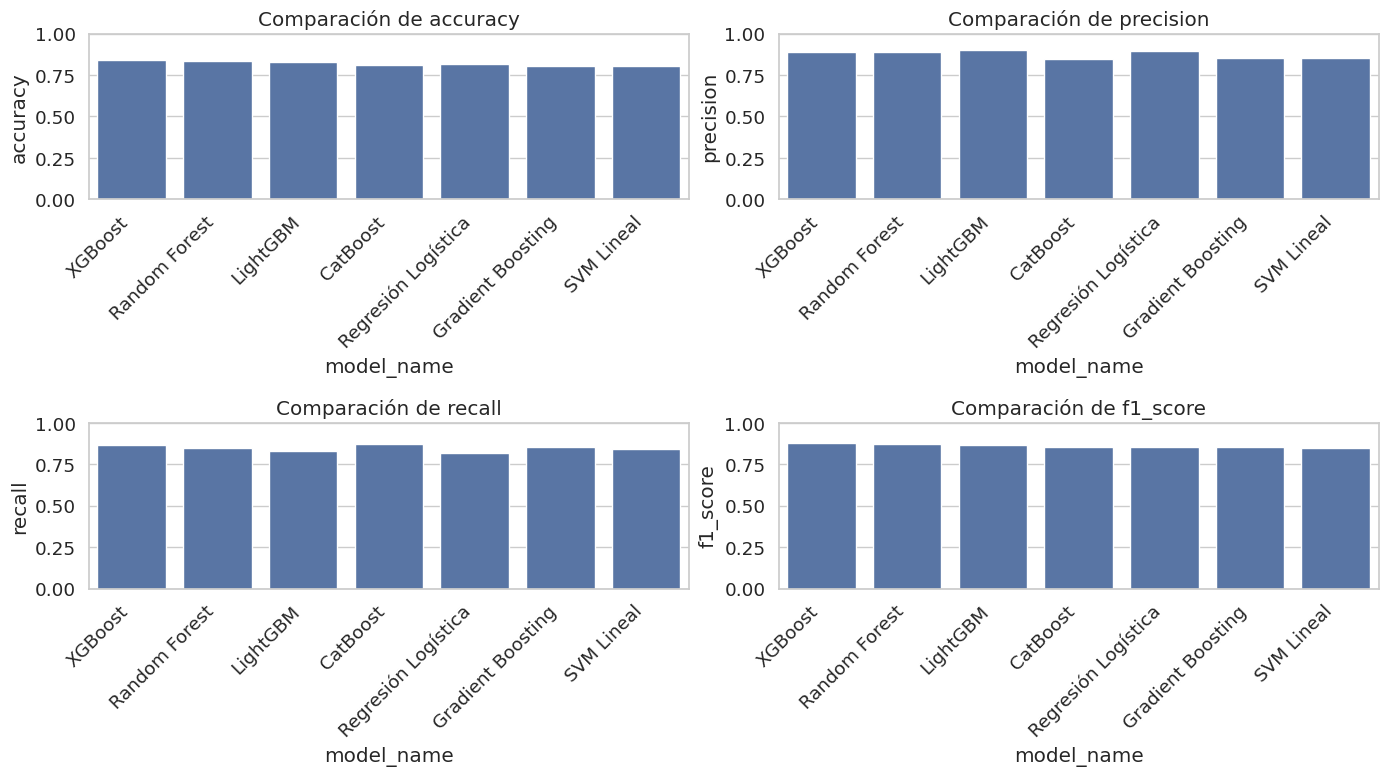


=== OPTIMIZACIÓN DEL MEJOR MODELO ===
Mejor modelo seleccionado: XGBoost con F1-Score: 0.8774
Realizando búsqueda de hiperparámetros para XGBoost...
Parámetros a explorar: {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]}
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Mejores parámetros encontrados:
  • learning_rate: 0.1
  • max_depth: 7
  • min_child_weight: 3
  • n_estimators: 200

Evaluando modelo optimizado en validación:

=== Resultados para XGBoost (Optimizado) ===
Precisión (Accuracy): 0.8253
Precisión (Precision): 0.8746
Exhaustividad (Recall): 0.8561
F1-Score: 0.8652
AUC-ROC: 0.9154
Tiempo de entrenamiento: 41.75 segundos


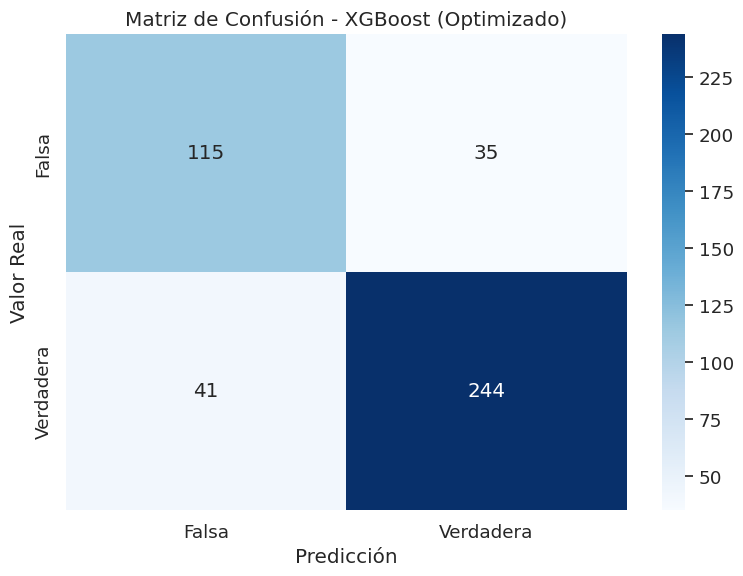

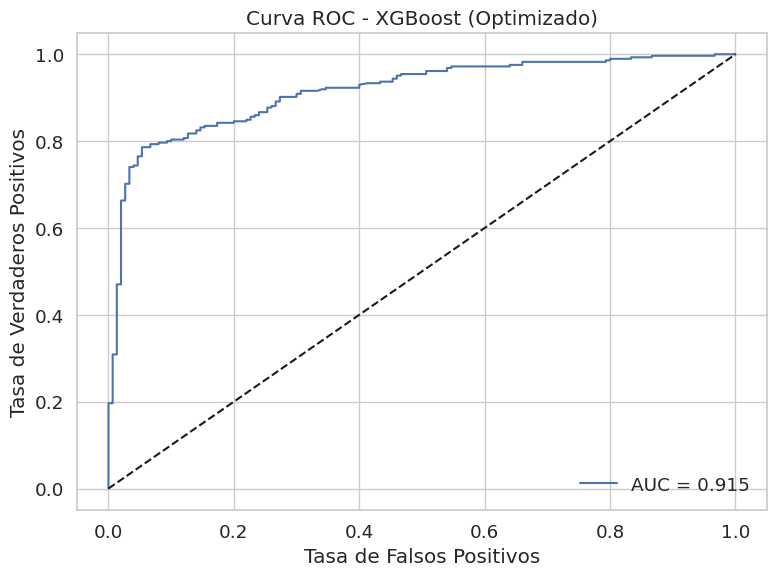


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.74      0.77      0.75       150
   Verdadera       0.87      0.86      0.87       285

    accuracy                           0.83       435
   macro avg       0.81      0.81      0.81       435
weighted avg       0.83      0.83      0.83       435


Evaluando modelo optimizado en conjunto de prueba:

=== Resultados para XGBoost (Optimizado - Test) ===
Precisión (Accuracy): 0.8126
Precisión (Precision): 0.8551
Exhaustividad (Recall): 0.8596
F1-Score: 0.8574
AUC-ROC: 0.8933
Tiempo de entrenamiento: 42.34 segundos


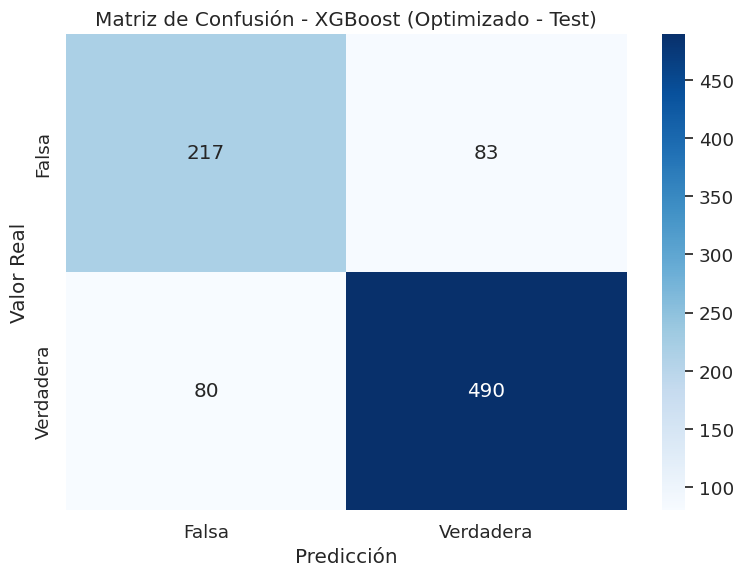

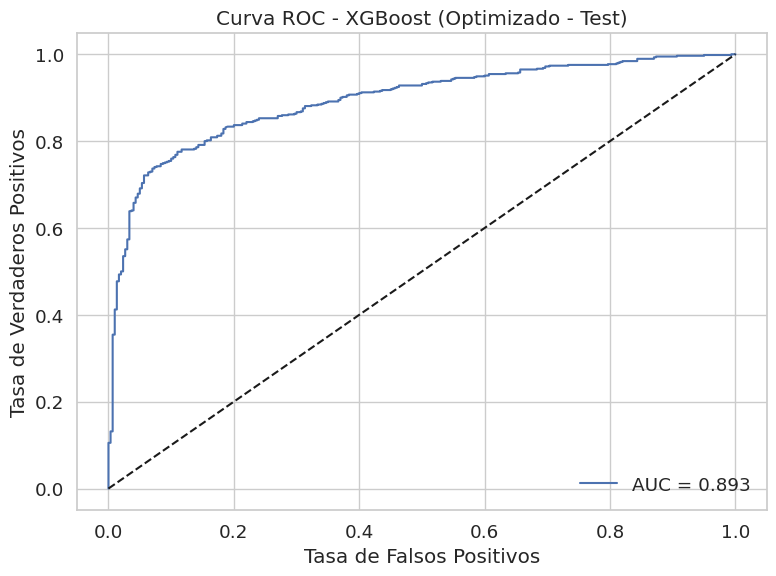


Informe de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.73      0.72      0.73       300
   Verdadera       0.86      0.86      0.86       570

    accuracy                           0.81       870
   macro avg       0.79      0.79      0.79       870
weighted avg       0.81      0.81      0.81       870


Mejora en F1-Score después de optimización: -0.0122 (-1.22%)

=== ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES ===
Analizando importancia de características para XGBoost...

Características más importantes:


,feature,importance
7504,prediction true,0.057204
6331,num,0.009442
2111,content,0.008603
2260,coronavirus,0.007945
1725,coalicion,0.007702
5153,julio,0.007624
7350,podra,0.006950
8742,seguridad,0.006679
7944,puntualacer,0.006075
9322,titular,0.005874


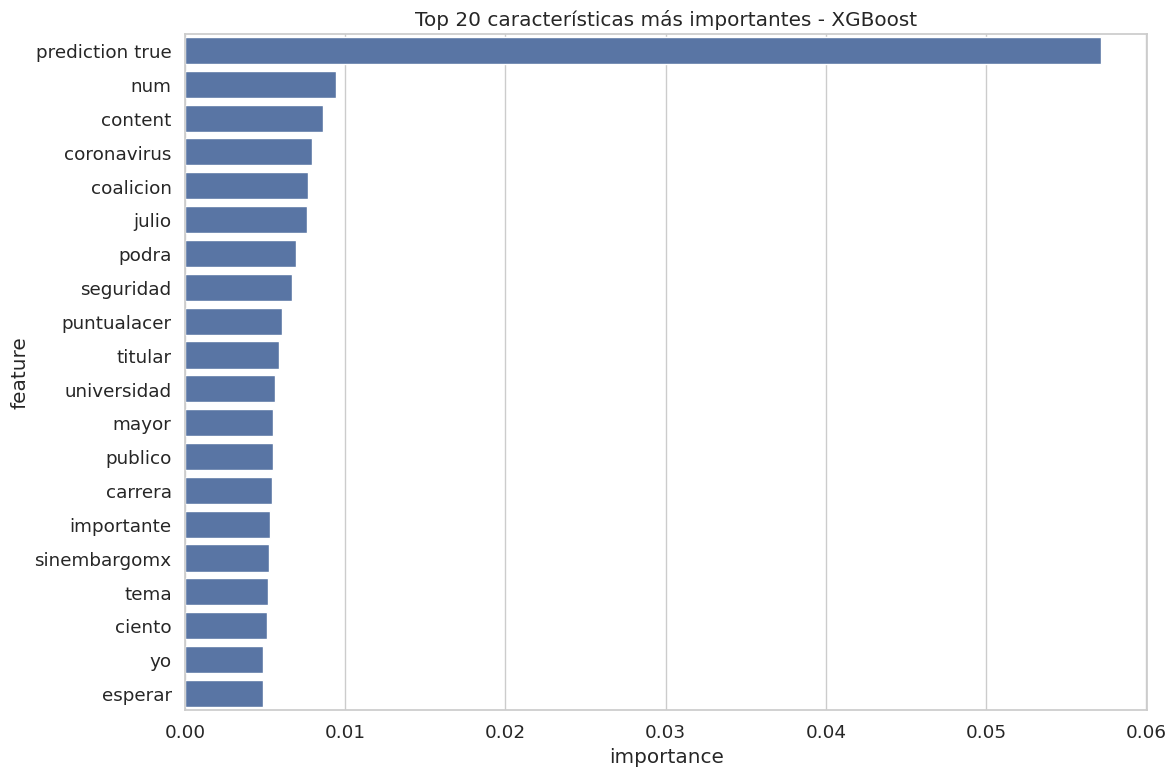


=== IMPLEMENTACIÓN DE MODELO FINAL ===
✅ Modelo guardado exitosamente como 'fake_news_detector_es.pkl'

=== DEMOSTRACIÓN DEL DETECTOR ===

EJEMPLO 1:
Título: La OMS confirma nuevo brote de gripe aviar en Europa
Contenido: La Organización Mundial de la Salud (OMS) ha confirmado hoy un nuevo brote de gripe aviar en varios ...

RESULTADO: Verdadera
Confianza: Baja (0.5472)

No se detectaron factores de riesgo significativos.

Recomendación: Esta noticia parece legítima, pero siempre es recomendable verificar con múltiples fuentes. El nivel de confianza es bajo, por lo que se recomienda especial cautela.

EJEMPLO 2:
Título: ¡INCREÍBLE! DESCUBREN QUE EL AGUA DE MAR CURA EL CÁNCER EN 24 HORAS!!!
Contenido: Científicos secretos que no quieren ser identificados han descubierto que beber agua de mar en luna ...

RESULTADO: Verdadera
Confianza: Alta (0.8827)

Factores de riesgo detectados:
 • Puntuación excesiva (Medio): Detectados 4 signos de exclamación y 0 de interrogación
 • Uso excesivo de

In [13]:
# === CARGA Y PREPARACIÓN DE DATOS ===
print("\n=== CARGA DE DATOS ===")

def load_data(file_path):
    """Carga el dataset con manejo de errores y diagnóstico."""
    try:
        start_time = time.time()
        df = pd.read_csv(file_path)
        print(f"Dataset cargado con {df.shape[0]} registros y {df.shape[1]} columnas.")
        print(f"Tiempo de carga: {time.time() - start_time:.2f} segundos.")

        # Eliminar columna split que no es funcional
        if 'split' in df.columns:
            df = df.drop(columns=['split'])
            print("Columna 'split' eliminada del dataset.")

        # Verificar memoria utilizada
        mem_usage = df.memory_usage(deep=True).sum() / 1024**2
        print(f"Uso de memoria: {mem_usage:.2f} MB")

        # Verificar valores nulos
        null_counts = df.isnull().sum()
        if null_counts.sum() > 0:
            print("\nValores nulos por columna:")
            print(null_counts[null_counts > 0])
        else:
            print("No hay valores nulos en el dataset.")

        # Mostrar distribución de clases
        print("\nDistribución de clases:")
        if 'label' in df.columns:
            class_dist = df['label'].value_counts(normalize=True) * 100
            display(pd.DataFrame({
                'Counts': df['label'].value_counts(),
                'Percentage': class_dist
            }))

        # Muestra de datos
        print("\nPrimeras filas del dataset:")
        display(df.head(3))

        return df

    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        print("Asegúrate de que 'fake_news_combined_clean.csv' está en la carpeta correcta.")
        raise

# Cargar el dataset (cambia a tu ruta)
combined_clean_path = "/content/fake_news_combined_clean.csv"
df = load_data(combined_clean_path)

# === PREPROCESAMIENTO DE ETIQUETAS ===
print("\n=== PREPROCESAMIENTO DE ETIQUETAS ===")

def prepare_labels(df):
    """Prepara y estandariza las etiquetas."""
    # Verificar tipo de etiquetas
    if 'label' not in df.columns:
        raise ValueError("El dataset debe contener una columna 'label'")

    # Crear copia para no modificar el original
    df_proc = df.copy()

    # Detectar nombres de etiquetas
    label_unique = df_proc['label'].unique()
    print(f"Etiquetas únicas encontradas: {label_unique}")

    # Mapeo de etiquetas
    if df_proc['label'].dtype == 'object':
        # Primero intentar un enfoque basado en palabras clave
        label_map = {}
        for label in label_unique:
            if any(word in str(label).lower() for word in ['falsa', 'fake', 'false', 'bulo', 'rumor', 'mentira']):
                label_map[label] = 0  # Falsa = 0
            else:
                label_map[label] = 1  # Verdadera = 1

        # Aplicar mapeo
        df_proc['label_num'] = df_proc['label'].map(label_map)
    else:
        # Si ya es numérica, asegurar valores binarios
        df_proc['label_num'] = df_proc['label'].apply(lambda x: 1 if x > 0 else 0)

    # Verificar conversión
    print("\nDistribución después del mapeo:")
    label_num_dist = df_proc['label_num'].value_counts(normalize=True) * 100
    display(pd.DataFrame({
        'Counts': df_proc['label_num'].value_counts(),
        'Percentage': label_num_dist
    }))

    # Crear etiquetas textuales para legibilidad
    df_proc['label_text'] = df_proc['label_num'].map({0: 'Falsa', 1: 'Verdadera'})

    return df_proc

# Preprocesar etiquetas
df_processed = prepare_labels(df)

# === ANÁLISIS EXPLORATORIO AVANZADO ===
print("\n=== ANÁLISIS EXPLORATORIO DE DATOS ===")

def exploratory_analysis(df, text_columns=['title', 'content']):
    """Realiza un análisis exploratorio enfocado en datos textuales."""
    # Estadísticas básicas de longitud
    print("Estadísticas de longitud:")

    stats = {}
    for col in text_columns:
        if col in df.columns:
            # Longitud de texto
            df[f'{col}_length'] = df[col].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)

            # Contar palabras
            df[f'{col}_word_count'] = df[col].apply(
                lambda x: len(str(x).split()) if isinstance(x, str) else 0
            )

            # Estadísticas
            stats[f'{col}_length'] = df[f'{col}_length'].describe()
            stats[f'{col}_word_count'] = df[f'{col}_word_count'].describe()

    # Mostrar estadísticas
    for name, stat in stats.items():
        print(f"\n{name.capitalize()}:")
        display(stat)

    # Visualizar distribución de longitud por clase
    fig, axes = plt.subplots(len(text_columns), 2, figsize=(16, 6*len(text_columns)))

    for i, col in enumerate(text_columns):
        if col in df.columns:
            # Longitud de texto
            sns.histplot(
                data=df, x=f'{col}_length', hue='label_text',
                bins=30, kde=True, ax=axes[i, 0]
            )
            axes[i, 0].set_title(f'Distribución de longitud de {col} por clase')
            axes[i, 0].set_xlabel('Longitud (caracteres)')

            # Conteo de palabras
            sns.histplot(
                data=df, x=f'{col}_word_count', hue='label_text',
                bins=30, kde=True, ax=axes[i, 1]
            )
            axes[i, 1].set_title(f'Distribución de palabras en {col} por clase')
            axes[i, 1].set_xlabel('Número de palabras')

    plt.tight_layout()
    plt.show()

    # Análisis de palabras más comunes por clase
    print("\nPalabras más frecuentes por clase:")

    # Solo usar stopwords si NLTK está disponible
    try:
        stop_words = set(stopwords.words('spanish'))
    except:
        stop_words = set()

    for col in text_columns:
        if col in df.columns:
            # Separar por clase
            real_texts = df[df['label_num'] == 1][col].astype(str)
            fake_texts = df[df['label_num'] == 0][col].astype(str)

            # Función para contar palabras
            def get_top_words(texts, n=20):
                words = []
                for text in texts:
                    words.extend([word.lower() for word in re.findall(r'\b\w+\b', text)
                                 if word.lower() not in stop_words and len(word) > 2])
                return Counter(words).most_common(n)

            # Contar
            real_top = get_top_words(real_texts)
            fake_top = get_top_words(fake_texts)

            # Mostrar
            print(f"\nPalabras más comunes en {col} - Noticias VERDADERAS:")
            display(pd.DataFrame(real_top, columns=['Palabra', 'Frecuencia']))

            print(f"\nPalabras más comunes en {col} - Noticias FALSAS:")
            display(pd.DataFrame(fake_top, columns=['Palabra', 'Frecuencia']))

            # Visualizar
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

            # Real news
            real_df = pd.DataFrame(real_top, columns=['word', 'count']).sort_values('count')
            fake_df = pd.DataFrame(fake_top, columns=['word', 'count']).sort_values('count')

            sns.barplot(data=real_df.tail(15), y='word', x='count', ax=ax1, palette='Blues_d')
            ax1.set_title(f'Top 15 palabras en noticias VERDADERAS ({col})')

            sns.barplot(data=fake_df.tail(15), y='word', x='count', ax=ax2, palette='Reds_d')
            ax2.set_title(f'Top 15 palabras en noticias FALSAS ({col})')

            plt.tight_layout()
            plt.show()

    return df

# Análisis exploratorio (solo si el dataset no es muy grande)
if len(df_processed) < 20000:
    df_processed = exploratory_analysis(df_processed)
else:
    # Usar una muestra para el análisis
    sample_for_analysis = df_processed.sample(n=10000, random_state=RANDOM_SEED)
    print("Usando una muestra de 10,000 registros para el análisis exploratorio...")
    exploratory_analysis(sample_for_analysis)

# === PREPROCESAMIENTO AVANZADO DE TEXTO ===
print("\n=== PREPROCESAMIENTO AVANZADO DE TEXTO ===")

# Lista ampliada de stopwords en español
try:
    spanish_stopwords = set(stopwords.words('spanish'))
    spanish_stopwords.update(['si', 'así', 'vez', 'aunque', 'mediante', 'pues', 'tras'])
except:
    spanish_stopwords = set(['si', 'así', 'vez', 'aunque', 'mediante', 'pues', 'tras',
                             'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'y',
                             'de', 'del', 'a', 'en', 'con', 'por', 'para', 'al', 'que',
                             'se', 'su', 'sus', 'o', 'como', 'pero', 'sin', 'sobre'])

# Expresiones regulares precompiladas para mejor rendimiento
url_pattern = re.compile(r'http\S+|www\S+|https\S+')
html_pattern = re.compile(r'<.*?>')
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticonos
                           u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
                           u"\U0001F680-\U0001F6FF"  # símbolos de transporte y mapas
                           u"\U0001F700-\U0001F77F"  # símbolos alquímicos
                           u"\U0001F780-\U0001F7FF"  # símbolos geométricos
                           u"\U0001F800-\U0001F8FF"  # símbolos miscellaneous
                           u"\U0001F900-\U0001F9FF"  # símbolos suplementarios
                           u"\U0001FA00-\U0001FA6F"  # símbolos extendidos
                           u"\U0001FA70-\U0001FAFF"  # símbolos extendidos-A
                           u"\U00002702-\U000027B0"  # dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
digits_pattern = re.compile(r'\d+')
spaces_pattern = re.compile(r'\s+')
punctuation_pattern = re.compile(r'[^\w\s]')

def remove_accents(text):
    """Elimina acentos y caracteres especiales."""
    try:
        import unicodedata
        return ''.join(c for c in unicodedata.normalize('NFD', text)
                      if unicodedata.category(c) != 'Mn')
    except:
        # Fallback simple si hay problemas con unicodedata
        replacements = {
            'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
            'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
            'ñ': 'n', 'Ñ': 'N', 'ü': 'u', 'Ü': 'U'
        }
        for old, new in replacements.items():
            text = text.replace(old, new)
        return text

def basic_preprocess_text(text, remove_accents_flag=True):
    """Preprocesamiento básico que funciona sin depender de bibliotecas externas."""
    if not isinstance(text, str) or not text.strip():
        return ""

    # Eliminación de URLs
    text = url_pattern.sub('', text)

    # Eliminación de etiquetas HTML
    text = html_pattern.sub('', text)

    # Eliminación de emojis
    text = emoji_pattern.sub('', text)

    # Normalización a minúsculas
    text = text.lower()

    # Eliminación de acentos
    if remove_accents_flag:
        text = remove_accents(text)

    # Reemplazar números
    text = digits_pattern.sub(' NUM ', text)

    # Eliminación de puntuación
    text = punctuation_pattern.sub(' ', text)

    # Eliminación de espacios múltiples
    text = spaces_pattern.sub(' ', text).strip()

    # Eliminación básica de stopwords
    if spanish_stopwords:
        words = text.split()
        text = ' '.join([word for word in words if word not in spanish_stopwords])

    return text

def spacy_preprocess_text(text, remove_accents_flag=True):
    """Preprocesamiento avanzado usando spaCy (si está disponible)."""
    if not isinstance(text, str) or not text.strip():
        return ""

    # Aplicar preprocesamiento básico primero
    text = basic_preprocess_text(text, remove_accents_flag)

    # Lematización con spaCy
    try:
        doc = nlp(text)
        lemmas = [token.lemma_ for token in doc
                 if not token.is_stop and len(token.lemma_) > 1]
        return ' '.join(lemmas)
    except Exception as e:
        print(f"Error en lematización: {e}")
        return text  # Fallback al preprocesamiento básico

def preprocess_text(text, use_spacy=True, remove_accents_flag=True):
    """Función unificada de preprocesamiento que elige el mejor método disponible."""
    if use_spacy and has_spacy:
        return spacy_preprocess_text(text, remove_accents_flag)
    else:
        return basic_preprocess_text(text, remove_accents_flag)

# Función para procesar los textos en lotes
def batch_process_texts(texts, use_spacy=True, batch_size=1000):
    """Procesa textos en lotes para mejor manejo de memoria."""
    processed_texts = []
    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in tqdm(range(total_batches), desc="Procesando textos en lotes"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(texts))
        batch = texts[start_idx:end_idx]

        # Procesar cada texto en el lote
        processed_batch = [preprocess_text(text, use_spacy) for text in batch]
        processed_texts.extend(processed_batch)

        # Liberar memoria
        if i % 5 == 0:
            gc.collect()

    return processed_texts

# Función para preprocesar el dataset completo
def preprocess_dataset(df, text_columns=['title', 'content'], use_spacy=True):
    """Preprocesa las columnas de texto del dataset."""
    df_proc = df.copy()

    for col in text_columns:
        if col in df_proc.columns:
            print(f"Procesando columna '{col}'...")

            # Preprocesar textos en lotes
            clean_texts = batch_process_texts(df_proc[col].fillna('').values, use_spacy)
            df_proc[f'clean_{col}'] = clean_texts

            # Verificar resultado
            print(f"Longitud promedio de '{col}' original: {df_proc[col].fillna('').str.len().mean():.1f} caracteres")
            print(f"Longitud promedio de '{col}' procesado: {df_proc[f'clean_{col}'].str.len().mean():.1f} caracteres")

            # Mostrar ejemplos
            print("\nEjemplos de preprocesamiento:")
            for i in range(min(3, len(df_proc))):
                print(f"\nOriginal {i+1}: {df_proc[col].iloc[i][:200]}...")
                print(f"Procesado {i+1}: {df_proc[f'clean_{col}'].iloc[i][:200]}...")

    # Combinar para análisis (dar más peso al título repitiéndolo)
    df_proc['combined_text'] = df_proc.apply(
        lambda x: (x.get('clean_title', '') + " " +
                  x.get('clean_title', '') + " " +
                  x.get('clean_content', '')).strip(),
        axis=1
    )

    return df_proc

# Manejar valores nulos en el dataset
print("\n=== MANEJO DE VALORES NULOS ===")
def handle_missing_values(df):
    """Maneja valores nulos en el dataset para asegurar calidad de datos."""
    df_clean = df.copy()

    # Mostrar cantidad de valores nulos por columna
    null_counts = df_clean.isnull().sum()
    print("Valores nulos por columna antes de limpieza:")
    for col, count in null_counts.items():
        if count > 0:
            print(f"  {col}: {count} ({count/len(df_clean)*100:.2f}%)")

    # Estrategia para cada columna
    # 1. Para columnas de texto: reemplazar nulos con string vacío
    text_cols = ['title', 'content']
    for col in text_cols:
        if col in df_clean.columns:
            missing = df_clean[col].isnull().sum()
            if missing > 0:
                print(f"Reemplazando {missing} valores nulos en '{col}' con string vacío")
                df_clean[col] = df_clean[col].fillna('')

    # 2. Para columnas categóricas: considerar imputar con moda o crear categoría "desconocido"
    cat_cols = ['source', 'dataset']
    for col in cat_cols:
        if col in df_clean.columns:
            missing = df_clean[col].isnull().sum()
            if missing > 0:
                mode_val = df_clean[col].mode()[0]
                print(f"Reemplazando {missing} valores nulos en '{col}' con el valor más común: '{mode_val}'")
                df_clean[col] = df_clean[col].fillna(mode_val)

    # Verificar que no hay más valores nulos
    remaining_nulls = df_clean.isnull().sum().sum()
    if remaining_nulls > 0:
        print(f"Atención: Aún quedan {remaining_nulls} valores nulos en el dataset")
    else:
        print("Todos los valores nulos han sido manejados correctamente.")

    return df_clean

# Manejar valores nulos
df_processed = handle_missing_values(df_processed)

# Dividir el dataset en conjuntos de entrenamiento y prueba
print("\n=== DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA ===")
def train_test_stratified_split(df, test_size=0.2, val_size=0.1):
    """Divide el dataset en conjuntos de entrenamiento, validación y prueba de forma estratificada."""
    # Primera división: separar conjunto de prueba
    train_val, test = train_test_split(
        df,
        test_size=test_size,
        random_state=RANDOM_SEED,
        stratify=df['label_num']
    )

    # Segunda división: separar conjunto de validación del entrenamiento
    if val_size > 0:
        train, val = train_test_split(
            train_val,
            test_size=val_size/(1-test_size),  # Ajustar proporción
            random_state=RANDOM_SEED,
            stratify=train_val['label_num']
        )

        print(f"Dataset dividido en:")
        print(f"  • Entrenamiento: {len(train)} registros ({len(train)/len(df)*100:.1f}%)")
        print(f"  • Validación: {len(val)} registros ({len(val)/len(df)*100:.1f}%)")
        print(f"  • Prueba: {len(test)} registros ({len(test)/len(df)*100:.1f}%)")

        return train, val, test
    else:
        print(f"Dataset dividido en:")
        print(f"  • Entrenamiento: {len(train_val)} registros ({len(train_val)/len(df)*100:.1f}%)")
        print(f"  • Prueba: {len(test)} registros ({len(test)/len(df)*100:.1f}%)")

        return train_val, test

# Dividir dataset
train_df, val_df, test_df = train_test_stratified_split(df_processed)

# Verificar distribución de clases en cada conjunto
def check_class_distribution(train, val, test):
    """Verifica la distribución de clases en cada conjunto para confirmar estratificación."""
    print("\nDistribución de clases:")

    datasets = {
        "Entrenamiento": train,
        "Validación": val,
        "Prueba": test
    }

    for name, dataset in datasets.items():
        class_counts = dataset['label_num'].value_counts()
        class_percentages = class_counts / len(dataset) * 100

        print(f"\n{name}:")
        for i, count in enumerate(class_counts):
            class_name = "Falsa" if i == 0 else "Verdadera"
            print(f"  • {class_name}: {count} registros ({class_percentages[i]:.2f}%)")

# Verificar distribución
check_class_distribution(train_df, val_df, test_df)

# Ahora sí preprocesamos el texto, pero usaremos el conjunto de entrenamiento completo
print("\n=== PREPROCESAMIENTO DE TEXTO EN CONJUNTO DE ENTRENAMIENTO ===")
print(f"Procesando {len(train_df)} registros de entrenamiento...")

# Preprocesar los textos
train_preprocessed = preprocess_dataset(train_df, use_spacy=has_spacy)

# === EXTRACCIÓN DE CARACTERÍSTICAS AVANZADA ===
print("\n=== EXTRACCIÓN DE CARACTERÍSTICAS AVANZADA ===")

# Lista de palabras sensacionalistas en español
sensational_words = [
    'increíble', 'impactante', 'asombroso', 'urgente', 'viral',
    'escándalo', 'secreto', 'exclusiva', 'prohibido', 'censurado',
    'impresionante', 'alarmante', 'sorprendente', 'aterrador',
    'insólito', 'extraordinario', 'explosivo', 'inaudito', 'histórico',
    'descomunal', 'tremendo', 'escalofriante', 'espectacular', 'milagroso',
    'revolucionario', 'extremo', 'dramático', 'catastrófico', 'terrorífico'
]

def extract_linguistic_features(row):
    """Extrae características lingüísticas del texto."""
    title = row.get('clean_title', '')
    content = row.get('clean_content', '')
    orig_title = row.get('title', '')
    orig_content = row.get('content', '')

    # Asegurar que son strings
    title = str(title) if title is not None else ""
    content = str(content) if content is not None else ""
    orig_title = str(orig_title) if orig_title is not None else ""
    orig_content = str(orig_content) if orig_content is not None else ""

    features = {}

    # Características de longitud
    features['title_length'] = len(title)
    features['title_word_count'] = len(title.split())
    features['content_length'] = len(content)
    features['content_word_count'] = len(content.split())

    # Características de puntuación (en texto original para mantener puntuación)
    features['title_exclamation_count'] = orig_title.count('!')
    features['title_question_count'] = orig_title.count('?')
    features['content_exclamation_count'] = orig_content.count('!')
    features['content_question_count'] = orig_content.count('?')

    # Palabras sensacionalistas
    title_lower = title.lower()
    content_lower = content.lower()

    features['title_sensational_count'] = sum(1 for word in sensational_words if word in title_lower)
    features['content_sensational_count'] = sum(1 for word in sensational_words if word in content_lower)

    # Presencia de números
    features['title_number_count'] = len(re.findall(r'\bNUM\b', title))
    features['content_number_count'] = len(re.findall(r'\bNUM\b', content))

    # Características de mayúsculas (en texto original)
    features['title_uppercase_ratio'] = (
        sum(1 for c in orig_title if c.isupper()) / max(1, len(orig_title))
    )

    # Características específicas de fake news

    # 1. Ratio título/contenido (títulos demasiado largos pueden ser sospechosos)
    if features['content_word_count'] > 0:
        features['title_content_ratio'] = features['title_word_count'] / features['content_word_count']
    else:
        features['title_content_ratio'] = 0

    # 2. Densidad de puntuación sensacionalista
    if features['title_word_count'] > 0:
        features['title_excl_quest_density'] = (
            (features['title_exclamation_count'] + features['title_question_count']) /
            features['title_word_count']
        )
    else:
        features['title_excl_quest_density'] = 0

    # 3. Sensacionalismo por densidad
    if features['title_word_count'] > 0:
        features['title_sensational_density'] = features['title_sensational_count'] / features['title_word_count']
    else:
        features['title_sensational_density'] = 0

    if features['content_word_count'] > 0:
        features['content_sensational_density'] = features['content_sensational_count'] / features['content_word_count']
    else:
        features['content_sensational_density'] = 0

    # 4. Complejidad léxica (aproximada por longitud media de palabra)
    if features['title_word_count'] > 0:
        title_words = title.split()
        features['title_avg_word_length'] = sum(len(word) for word in title_words) / features['title_word_count']
    else:
        features['title_avg_word_length'] = 0

    # 5. Incongruencia entre título y contenido (si hay muchas palabras en el título que no están en el contenido)
    title_words = set(title.split())
    content_words = set(content.split())

    if len(title_words) > 0:
        features['title_content_word_mismatch'] = len(title_words - content_words) / len(title_words)
    else:
        features['title_content_word_mismatch'] = 0

    # 6. Presencia de números redondos (como "100%", "miles", etc.) que suelen exagerar
    features['has_round_numbers'] = 1 if re.search(r'\b(100%|miles|millones|todos|ninguno)\b',
                                                 title_lower + ' ' + content_lower) else 0

    return features

# Extraer características lingüísticas directamente, sin almacenar en un DataFrame intermedio
print("Extrayendo características lingüísticas...")

# Recolectar todas las características en un solo paso para cada conjunto de datos
train_features = {}
for idx, row in tqdm(train_preprocessed.iterrows(), total=len(train_preprocessed), desc="Procesando entrenamiento"):
    features = extract_linguistic_features(row)
    for key, value in features.items():
        if key not in train_features:
            train_features[key] = []
        train_features[key].append(value)

# Convertir a DataFrame
train_features_df = pd.DataFrame(train_features)

# Verificar características numéricas
print("\nCaracterísticas lingüísticas extraídas:")
for col in train_features_df.columns:
    print(f"  • {col}: {train_features_df[col].dtype}")

# Unir con datos preprocesados
train_df_features = train_preprocessed.copy()
for col in train_features_df.columns:
    train_df_features[col] = train_features_df[col]

print(f"Total de características extraídas: {len(train_features_df.columns)}")

# Repetir para validación
print("\nExtrayendo características para validación...")
val_features = {}
for idx, row in tqdm(val_preprocessed.iterrows(), total=len(val_preprocessed), desc="Procesando validación"):
    features = extract_linguistic_features(row)
    for key, value in features.items():
        if key not in val_features:
            val_features[key] = []
        val_features[key].append(value)

val_features_df = pd.DataFrame(val_features)
val_df_features = val_preprocessed.copy()
for col in val_features_df.columns:
    val_df_features[col] = val_features_df[col]

# Repetir para test
print("\nExtrayendo características para prueba...")
test_features = {}
for idx, row in tqdm(test_preprocessed.iterrows(), total=len(test_preprocessed), desc="Procesando prueba"):
    features = extract_linguistic_features(row)
    for key, value in features.items():
        if key not in test_features:
            test_features[key] = []
        test_features[key].append(value)

test_features_df = pd.DataFrame(test_features)
test_df_features = test_preprocessed.copy()
for col in test_features_df.columns:
    test_df_features[col] = test_features_df[col]

# === PROCESANDO CONJUNTOS DE VALIDACIÓN Y PRUEBA ===
print("\n=== PROCESAMIENTO DE CONJUNTOS DE VALIDACIÓN Y PRUEBA ===")

# Preprocesar conjunto de validación
print(f"Procesando {len(val_df)} registros de validación...")
val_preprocessed = preprocess_dataset(val_df, use_spacy=has_spacy)

# Preprocesar conjunto de prueba
print(f"Procesando {len(test_df)} registros de prueba...")
test_preprocessed = preprocess_dataset(test_df, use_spacy=has_spacy)

# === VECTORIZACIÓN DE TEXTO Y PREPARACIÓN FINAL DE CARACTERÍSTICAS ===
print("\n=== PREPARACIÓN FINAL DE CARACTERÍSTICAS ===")

def prepare_feature_vectors(train_df, val_df, test_df,
                           text_col='combined_text',
                           feature_cols=None,
                           max_features=10000):
    """
    Prepara vectores de características combinando TF-IDF con características lingüísticas.

    Args:
        train_df: DataFrame de entrenamiento
        val_df: DataFrame de validación
        test_df: DataFrame de prueba
        text_col: Columna con el texto combinado para TF-IDF
        feature_cols: Lista de columnas de características lingüísticas
        max_features: Número máximo de características para TF-IDF

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, vectorizers
    """
    # Solución completa: Forzar una lista de características lingüísticas explícita
    # basada en columnas que sabemos que existen en los DataFrames
    if feature_cols is None:
        # Lista predefinida de características que esperamos tener
        expected_features = [
            'title_length', 'title_word_count', 'content_length', 'content_word_count',
            'title_exclamation_count', 'title_question_count', 'content_exclamation_count',
            'content_question_count', 'title_sensational_count', 'content_sensational_count',
            'title_number_count', 'content_number_count', 'title_uppercase_ratio',
            'title_content_ratio', 'title_excl_quest_density', 'title_sensational_density',
            'content_sensational_density', 'title_avg_word_length', 'title_content_word_mismatch'
        ]

        # Verificar cuáles de estas características existen en el DataFrame
        feature_cols = [col for col in expected_features if col in train_df.columns]

        if not feature_cols:
            # Si no se encuentra ninguna, usar un enfoque más general pero seguro
            print("No se encontraron características lingüísticas específicas. Usando un enfoque alternativo.")

            # Buscar columnas que parecen características numéricas por su nombre
            potential_features = [col for col in train_df.columns
                                if any(keyword in col for keyword in
                                    ['count', 'ratio', 'length', 'density', 'number', 'uppercase'])]

            # Verificar que sean numéricas de forma segura
            feature_cols = []
            for col in potential_features:
                try:
                    # Intentar convertir a numérico y ver si funciona
                    if pd.api.types.is_numeric_dtype(train_df[col]):
                        feature_cols.append(col)
                except:
                    # Si hay algún error, simplemente saltamos esta columna
                    pass

    # Verificación de seguridad final
    if not feature_cols:
        print("ADVERTENCIA: No se encontraron características lingüísticas. El modelo usará solo TF-IDF.")

    print(f"Usando {len(feature_cols)} características lingüísticas: {feature_cols}")

    # NUEVO: Imputar valores faltantes en las características
    print("Verificando valores NaN en características...")

    # Función para imputar NaNs en un DataFrame
    def impute_nans(df, cols):
        """Imputa valores NaN en las columnas especificadas del DataFrame."""
        df_imputed = df.copy()

        # Imputar con la mediana para características numéricas
        for col in cols:
            if col in df.columns:
                nan_count = df[col].isna().sum()
                if nan_count > 0:
                    print(f"  • Columna '{col}': {nan_count} valores NaN detectados")
                    # Imputar con la mediana
                    median_val = df[col].median()
                    df_imputed[col] = df[col].fillna(median_val)

        return df_imputed

    # Imputar NaNs en todos los conjuntos
    train_df = impute_nans(train_df, feature_cols + [text_col])
    val_df = impute_nans(val_df, feature_cols + [text_col])
    test_df = impute_nans(test_df, feature_cols + [text_col])

    # Vectorización de texto con TF-IDF
    print("Vectorizando texto con TF-IDF...")
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8,
        sublinear_tf=True
    )

    # Vectorizar conjunto de entrenamiento
    X_text_train = tfidf_vectorizer.fit_transform(train_df[text_col].fillna(''))
    print(f"Matriz TF-IDF de entrenamiento: {X_text_train.shape}")

    # Vectorizar conjuntos de validación y prueba
    X_text_val = tfidf_vectorizer.transform(val_df[text_col].fillna(''))
    X_text_test = tfidf_vectorizer.transform(test_df[text_col].fillna(''))

    # Extraer características lingüísticas si hay alguna
    if feature_cols:
        # Asegurarse de que todas las características están presentes en todos los conjuntos
        for df in [train_df, val_df, test_df]:
            for col in feature_cols:
                if col not in df.columns:
                    print(f"Característica '{col}' no encontrada. Añadiendo con valores 0.")
                    df[col] = 0

        X_features_train = train_df[feature_cols].values
        X_features_val = val_df[feature_cols].values
        X_features_test = test_df[feature_cols].values

        # Escalar características numéricas
        scaler = StandardScaler()
        X_features_train_scaled = scaler.fit_transform(X_features_train)
        X_features_val_scaled = scaler.transform(X_features_val)
        X_features_test_scaled = scaler.transform(X_features_test)

        # Combinar características (TF-IDF + lingüísticas)
        X_train = np.hstack((X_text_train.toarray(), X_features_train_scaled))
        X_val = np.hstack((X_text_val.toarray(), X_features_val_scaled))
        X_test = np.hstack((X_text_test.toarray(), X_features_test_scaled))
    else:
        # Si no hay características lingüísticas, usar solo TF-IDF
        X_train = X_text_train.toarray()
        X_val = X_text_val.toarray()
        X_test = X_text_test.toarray()
        scaler = None

    # NUEVO: Verificación final para asegurar que no hay NaN en los datos
    print("Verificando NaNs en matrices de características...")
    for name, matrix in [("X_train", X_train), ("X_val", X_val), ("X_test", X_test)]:
        nan_count = np.isnan(matrix).sum()
        if nan_count > 0:
            print(f"  ⚠️ ADVERTENCIA: {nan_count} valores NaN detectados en {name}")
            print("     Imputando con ceros...")
            # Reemplazar NaN con 0 como última opción
            matrix[np.isnan(matrix)] = 0
        else:
            print(f"  ✓ No se detectaron NaNs en {name}")

    print(f"Dimensiones finales:")
    print(f"  Entrenamiento: {X_train.shape}")
    print(f"  Validación: {X_val.shape}")
    print(f"  Prueba: {X_test.shape}")

    # Preparar etiquetas
    y_train = train_df['label_num'].values
    y_val = val_df['label_num'].values
    y_test = test_df['label_num'].values

    # Guardar vectorizadores para uso posterior
    vectorizers = {
        'tfidf': tfidf_vectorizer,
        'scaler': scaler,
        'feature_cols': feature_cols
    }

    return X_train, X_val, X_test, y_train, y_val, y_test, vectorizers

# Preparar características
print("Preparando vectores de características...")
X_train, X_val, X_test, y_train, y_val, y_test, vectorizers = prepare_feature_vectors(
    train_df_features, val_df_features, test_df_features
)

# === ENTRENAMIENTO Y EVALUACIÓN DE MODELOS ===
print("\n=== ENTRENAMIENTO Y EVALUACIÓN DE MODELOS ===")

# Calcular pesos de clase para manejar desbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Pesos de clase para manejo de desbalance: {class_weight_dict}")

# Definir función para evaluación de modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Modelo"):
    """Evalúa un modelo de clasificación con métricas detalladas."""
    start_time = time.time()

    # Entrenar modelo
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predecir
    y_pred = model.predict(X_test)

    # Calcular probabilidades si el modelo lo soporta
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        has_proba = True
    else:
        y_prob = None
        has_proba = False

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Métricas adicionales si hay probabilidades
    if has_proba:
        auc_score = roc_auc_score(y_test, y_prob)
    else:
        auc_score = None

    # Crear reporte
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_score,
        'training_time': training_time
    }

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Mostrar resultados
    print(f"\n=== Resultados para {model_name} ===")
    print(f"Precisión (Accuracy): {accuracy:.4f}")
    print(f"Precisión (Precision): {precision:.4f}")
    print(f"Exhaustividad (Recall): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auc_score:
        print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Falsa', 'Verdadera'],
               yticklabels=['Falsa', 'Verdadera'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.tight_layout()
    plt.show()

    # Curva ROC si hay probabilidades
    if has_proba:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    # Informe de clasificación detallado
    print("\nInforme de clasificación detallado:")
    print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

    return model, results

# Definir modelos a probar
models = {
    "Regresión Logística": LogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    ),
    "SVM Lineal": LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=2000,
        dual=False
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        random_state=RANDOM_SEED
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=RANDOM_SEED,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

# Añadir LightGBM
models["LightGBM"] = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    class_weight='balanced'
)

# Añadir CatBoost si está disponible
if has_catboost:
    models["CatBoost"] = cb.CatBoostClassifier(
        iterations=100,
        random_seed=RANDOM_SEED,
        verbose=False
    )

# Entrenar y evaluar cada modelo con validación
all_results = []
trained_models = {}

# Usar validación en lugar de prueba para no contaminar el conjunto de prueba final
for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    trained_model, results = evaluate_model(model, X_train, X_val, y_train, y_val, name)
    trained_models[name] = trained_model
    all_results.append(results)

# Mostrar tabla comparativa de resultados
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('f1_score', ascending=False)

print("\n=== COMPARACIÓN DE MODELOS ===")
display(results_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'auc', 'training_time']])

# Visualizar comparativa de métricas
plt.figure(figsize=(14, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Comparación de {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# === SELECCIONAR Y OPTIMIZAR EL MEJOR MODELO ===
print("\n=== OPTIMIZACIÓN DEL MEJOR MODELO ===")

# Seleccionar el mejor modelo basado en F1-Score
best_model_name = results_df.iloc[0]['model_name']
best_model = trained_models[best_model_name]
print(f"Mejor modelo seleccionado: {best_model_name} con F1-Score: {results_df.iloc[0]['f1_score']:.4f}")

# Definir parámetros para búsqueda de hiperparámetros
param_grids = {
    "Regresión Logística": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    "SVM Lineal": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'loss': ['hinge', 'squared_hinge'],
        'dual': [False]
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5]
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70]
    }
}

if has_catboost:
    param_grids["CatBoost"] = {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [4, 6, 8]
    }

# Seleccionar grid de parámetros para el mejor modelo
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]

    print(f"Realizando búsqueda de hiperparámetros para {best_model_name}...")
    print(f"Parámetros a explorar: {param_grid}")

    # Realizar búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(
        best_model,
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    # Ajustar al conjunto de entrenamiento
    grid_search.fit(X_train, y_train)

    # Mostrar mejores parámetros
    print(f"\nMejores parámetros encontrados:")
    for param, value in grid_search.best_params_.items():
        print(f"  • {param}: {value}")

    # Actualizar mejor modelo
    best_model_tuned = grid_search.best_estimator_

    # Evaluar en conjunto de validación
    print("\nEvaluando modelo optimizado en validación:")
    _, tuned_results = evaluate_model(
        best_model_tuned, X_train, X_val, y_train, y_val,
        f"{best_model_name} (Optimizado)"
    )

    # Evaluar en conjunto de prueba
    print("\nEvaluando modelo optimizado en conjunto de prueba:")
    _, test_results = evaluate_model(
        best_model_tuned, X_train, X_test, y_train, y_test,
        f"{best_model_name} (Optimizado - Test)"
    )

    # Comparar resultados originales vs optimizados
    improvement = tuned_results['f1_score'] - results_df.iloc[0]['f1_score']
    print(f"\nMejora en F1-Score después de optimización: {improvement:.4f} ({improvement*100:.2f}%)")

    # Guardar el mejor modelo
    best_model = best_model_tuned
else:
    print(f"No se definieron hiperparámetros para {best_model_name}. Usando modelo sin optimizar.")
    # Evaluar en conjunto de prueba
    print("\nEvaluando mejor modelo en conjunto de prueba:")
    _, test_results = evaluate_model(
        best_model, X_train, X_test, y_train, y_test,
        f"{best_model_name} (Test)"
    )

# === ANÁLISIS DE CARACTERÍSTICAS MÁS IMPORTANTES ===
print("\n=== ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES ===")

# Importancia de características para modelos basados en árboles
tree_based_models = ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM"]
if best_model_name in tree_based_models:
    print(f"Analizando importancia de características para {best_model_name}...")

    # Obtener importancia de características
    if best_model_name == "Random Forest":
        importances = best_model.feature_importances_
    elif best_model_name == "Gradient Boosting":
        importances = best_model.feature_importances_
    elif best_model_name == "XGBoost":
        importances = best_model.feature_importances_
    elif best_model_name == "LightGBM":
        importances = best_model.feature_importances_
    else:
        importances = None

    if importances is not None:
        # Crear nombres de características
        tfidf_feature_names = vectorizers['tfidf'].get_feature_names_out()
        feature_cols = vectorizers['feature_cols']

        # Combinar nombres
        all_feature_names = np.concatenate([tfidf_feature_names, feature_cols])

        # Verificar dimensiones
        if len(all_feature_names) == len(importances):
            # Crear DataFrame de importancias
            importance_df = pd.DataFrame({
                'feature': all_feature_names,
                'importance': importances
            })

            # Ordenar por importancia
            importance_df = importance_df.sort_values('importance', ascending=False)

            # Mostrar características más importantes
            print("\nCaracterísticas más importantes:")
            display(importance_df.head(20))

            # Visualizar top características
            plt.figure(figsize=(12, 8))
            sns.barplot(x='importance', y='feature', data=importance_df.head(20))
            plt.title(f'Top 20 características más importantes - {best_model_name}')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Error: Dimensiones no coinciden: {len(all_feature_names)} nombres vs {len(importances)} importancias")
elif best_model_name == "Regresión Logística":
    # Para regresión logística, podemos ver los coeficientes
    coef = best_model.coef_[0]

    # Crear nombres de características
    tfidf_feature_names = vectorizers['tfidf'].get_feature_names_out()
    feature_cols = vectorizers['feature_cols']
    all_feature_names = np.concatenate([tfidf_feature_names, feature_cols])

    # Verificar dimensiones
    if len(all_feature_names) == len(coef):
        # Crear DataFrame de coeficientes
        coef_df = pd.DataFrame({
            'feature': all_feature_names,
            'coefficient': coef
        })

        # Ordenar por valor absoluto del coeficiente
        coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
        coef_df = coef_df.sort_values('abs_coef', ascending=False)

        # Mostrar características más importantes
        print("\nCaracterísticas más importantes (por coeficiente):")
        display(coef_df.head(20))

        # Visualizar top características positivas y negativas
        plt.figure(figsize=(14, 8))

        plt.subplot(1, 2, 1)
        top_positive = coef_df[coef_df['coefficient'] > 0].head(10)
        sns.barplot(x='coefficient', y='feature', data=top_positive, palette='Blues_d')
        plt.title('Top 10 características predictoras de noticias VERDADERAS')

        plt.subplot(1, 2, 2)
        top_negative = coef_df[coef_df['coefficient'] < 0].head(10)
        sns.barplot(x='coefficient', y='feature', data=top_negative, palette='Reds_d')
        plt.title('Top 10 características predictoras de noticias FALSAS')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Dimensiones no coinciden: {len(all_feature_names)} nombres vs {len(coef)} coeficientes")
else:
    print(f"Análisis de características no implementado para modelo {best_model_name}")

# === IMPLEMENTACIÓN DE MODELO FINAL ===
print("\n=== IMPLEMENTACIÓN DE MODELO FINAL ===")

# Guardar componentes necesarios para detector de fake news
model_package = {
    'model': best_model,
    'vectorizers': vectorizers,
    'metadata': {
        'model_name': best_model_name,
        'f1_score': test_results['f1_score'],
        'accuracy': test_results['accuracy'],
        'precision': test_results['precision'],
        'recall': test_results['recall'],
        'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
    }
}

# Guardar el modelo
try:
    with open('fake_news_detector_es.pkl', 'wb') as f:
        pickle.dump(model_package, f)
    print("✅ Modelo guardado exitosamente como 'fake_news_detector_es.pkl'")
except Exception as e:
    print(f"❌ Error al guardar el modelo: {e}")
    # Intentar guardar en una ruta alternativa
    try:
        with open('/content/fake_news_detector_es.pkl', 'wb') as f:
            pickle.dump(model_package, f)
        print("✅ Modelo guardado exitosamente en '/content/fake_news_detector_es.pkl'")
    except Exception as e:
        print(f"❌ Error al guardar el modelo en ruta alternativa: {e}")

# Implementar detector final como clase
class FakeNewsDetector:
    """
    Detector de noticias falsas en español.

    Esta clase encapsula toda la lógica de preprocesamiento, extracción de características
    y clasificación para detectar si una noticia es falsa o verdadera.
    """

    def __init__(self, model_package=None):
        """
        Inicializa el detector ya sea con un paquete de modelo guardado o con el modelo actual.

        Args:
            model_package: Diccionario con el modelo y vectorizadores, o ruta a archivo .pkl
        """
        if model_package is None:
            # Usar modelo actual en memoria
            self.model = best_model
            self.vectorizers = vectorizers
            self.metadata = {
                'model_name': best_model_name,
                'f1_score': test_results['f1_score']
            }
        elif isinstance(model_package, str):
            # Cargar desde archivo
            try:
                with open(model_package, 'rb') as f:
                    package = pickle.load(f)
                self.model = package['model']
                self.vectorizers = package['vectorizers']
                self.metadata = package.get('metadata', {})
                print(f"Modelo cargado desde {model_package}")
            except Exception as e:
                raise ValueError(f"Error al cargar el modelo desde {model_package}: {e}")
        else:
            # Usar paquete pasado como argumento
            self.model = model_package['model']
            self.vectorizers = model_package['vectorizers']
            self.metadata = model_package.get('metadata', {})

    def preprocess_text(self, text):
        """
        Preprocesa un texto para análisis.

        Args:
            text: Texto a preprocesar

        Returns:
            Texto preprocesado
        """
        return preprocess_text(text, use_spacy=has_spacy, remove_accents_flag=True)

    def extract_features(self, title, content=""):
        """
        Extrae características lingüísticas de título y contenido.

        Args:
            title: Título de la noticia
            content: Contenido de la noticia (opcional)

        Returns:
            Diccionario con características extraídas
        """
        # Preprocesar textos
        clean_title = self.preprocess_text(title)
        clean_content = self.preprocess_text(content)

        # Combinar textos (dando más peso al título)
        combined_text = clean_title + " " + clean_title + " " + clean_content

        # Crear fila simulada para extracción de características
        row = {
            'title': title,
            'content': content,
            'clean_title': clean_title,
            'clean_content': clean_content
        }

        # Extraer características
        features = extract_linguistic_features(row)

        return combined_text, features

    def predict(self, title, content="", return_proba=False):
        """
        Predice si una noticia es falsa o verdadera.

        Args:
            title: Título de la noticia
            content: Contenido de la noticia (opcional)
            return_proba: Si es True, devuelve también la probabilidad

        Returns:
            Etiqueta (y probabilidad si return_proba=True)
        """
        # Extraer características
        combined_text, features = self.extract_features(title, content)

        # Vectorizar texto
        tfidf_vectorizer = self.vectorizers['tfidf']
        text_vector = tfidf_vectorizer.transform([combined_text])

        # Preparar características lingüísticas
        scaler = self.vectorizers['scaler']
        feature_cols = self.vectorizers['feature_cols']

        # Crear vector de características
        feature_values = [features.get(col, 0) for col in feature_cols]
        features_vector = np.array(feature_values).reshape(1, -1)

        # Escalar características
        features_scaled = scaler.transform(features_vector)

        # Combinar vectores
        X = np.hstack((text_vector.toarray(), features_scaled))

        # Predecir
        label = self.model.predict(X)[0]

        # Convertir a etiqueta de texto
        result = "Verdadera" if label == 1 else "Falsa"

        if return_proba and hasattr(self.model, 'predict_proba'):
            proba = self.model.predict_proba(X)[0]
            confidence = proba[1] if label == 1 else proba[0]
            return result, confidence

        return result

    def analyze(self, title, content=""):
        """
        Analiza una noticia y devuelve un informe detallado.

        Args:
            title: Título de la noticia
            content: Contenido de la noticia (opcional)

        Returns:
            Diccionario con resultado del análisis
        """
        # Predecir con probabilidad
        result, confidence = self.predict(title, content, return_proba=True)

        # Extraer características para análisis
        combined_text, features = self.extract_features(title, content)

        # Calcular factores de riesgo
        risk_factors = []

        # 1. Alto sensacionalismo en título
        title_sensational = features.get('title_sensational_count', 0)
        if title_sensational > 1:
            risk_factors.append({
                'factor': 'Sensacionalismo en título',
                'level': 'Alto' if title_sensational > 2 else 'Medio',
                'description': f'Detectadas {title_sensational} palabras sensacionalistas en el título'
            })

        # 2. Signos de exclamación/interrogación excesivos
        excl_count = features.get('title_exclamation_count', 0)
        quest_count = features.get('title_question_count', 0)
        if excl_count + quest_count > 2:
            risk_factors.append({
                'factor': 'Puntuación excesiva',
                'level': 'Alto' if excl_count + quest_count > 4 else 'Medio',
                'description': f'Detectados {excl_count} signos de exclamación y {quest_count} de interrogación'
            })

        # 3. Mayúsculas excesivas
        uppercase_ratio = features.get('title_uppercase_ratio', 0)
        if uppercase_ratio > 0.3:
            risk_factors.append({
                'factor': 'Uso excesivo de mayúsculas',
                'level': 'Alto' if uppercase_ratio > 0.5 else 'Medio',
                'description': f'{int(uppercase_ratio*100)}% del título está en mayúsculas'
            })

        # 4. Incongruencia título-contenido
        mismatch = features.get('title_content_word_mismatch', 0)
        if mismatch > 0.7 and features.get('content_length', 0) > 50:
            risk_factors.append({
                'factor': 'Incongruencia título-contenido',
                'level': 'Medio',
                'description': 'El título contiene palabras clave que apenas aparecen en el contenido'
            })

        # Recomendación final
        recommendation = "Esta noticia tiene alta probabilidad de ser falsa. Verifique con fuentes confiables antes de compartir." if result == "Falsa" else "Esta noticia parece legítima, pero siempre es recomendable verificar con múltiples fuentes."

        if confidence < 0.65:
            recommendation += " El nivel de confianza es bajo, por lo que se recomienda especial cautela."

        # Crear informe completo
        analysis = {
            'result': result,
            'confidence': confidence,
            'confidence_text': self._get_confidence_level(confidence),
            'risk_factors': risk_factors,
            'recommendation': recommendation,
            'model_info': {
                'name': self.metadata.get('model_name', 'Desconocido'),
                'accuracy': self.metadata.get('accuracy', 'No disponible')
            }
        }

        return analysis

    def _get_confidence_level(self, confidence):
        """Convierte nivel numérico de confianza a texto."""
        if confidence >= 0.9:
            return "Muy alta"
        elif confidence >= 0.75:
            return "Alta"
        elif confidence >= 0.6:
            return "Moderada"
        elif confidence >= 0.5:
            return "Baja"
        else:
            return "Muy baja"

# Crear instancia del detector
detector = FakeNewsDetector()

# === DEMOSTRACIÓN DE USO ===
print("\n=== DEMOSTRACIÓN DEL DETECTOR ===")

# Ejemplos de noticias para probar
ejemplos = [
    {
        'title': 'La OMS confirma nuevo brote de gripe aviar en Europa',
        'content': 'La Organización Mundial de la Salud (OMS) ha confirmado hoy un nuevo brote de gripe aviar en varios países de Europa. Según el informe presentado, se han detectado casos en granjas de Polonia, Alemania y Francia. Las autoridades sanitarias ya han activado los protocolos de seguridad.'
    },
    {
        'title': '¡INCREÍBLE! DESCUBREN QUE EL AGUA DE MAR CURA EL CÁNCER EN 24 HORAS!!!',
        'content': 'Científicos secretos que no quieren ser identificados han descubierto que beber agua de mar en luna llena elimina las células cancerígenas del cuerpo en tan solo 24 horas. Esta información ha sido CENSURADA por las grandes farmacéuticas que no quieren que se conozca este remedio natural y gratuito.'
    },
    {
        'title': 'Estudio muestra relación entre consumo de café y longevidad',
        'content': 'Un estudio realizado por investigadores de la Universidad de Harvard durante 10 años con una muestra de 500,000 personas muestra una correlación positiva entre el consumo moderado de café (2-3 tazas diarias) y una mayor esperanza de vida. Los compuestos antioxidantes del café podrían ser responsables de este efecto beneficioso.'
    }
]

# Analizar ejemplos
for i, ejemplo in enumerate(ejemplos):
    print(f"\n{'='*50}")
    print(f"EJEMPLO {i+1}:")
    print(f"Título: {ejemplo['title']}")
    print(f"Contenido: {ejemplo['content'][:100]}...")

    # Analizar con el detector
    analisis = detector.analyze(ejemplo['title'], ejemplo['content'])

    # Mostrar resultado
    print(f"\nRESULTADO: {analisis['result']}")
    print(f"Confianza: {analisis['confidence_text']} ({analisis['confidence']:.4f})")

    # Mostrar factores de riesgo
    if analisis['risk_factors']:
        print("\nFactores de riesgo detectados:")
        for factor in analisis['risk_factors']:
            print(f" • {factor['factor']} ({factor['level']}): {factor['description']}")
    else:
        print("\nNo se detectaron factores de riesgo significativos.")

    # Mostrar recomendación
    print(f"\nRecomendación: {analisis['recommendation']}")

# === CONCLUSIONES Y RECOMENDACIONES ===
print("\n=== CONCLUSIONES ===")
print("""
1. Rendimiento del modelo: Se ha desarrollado un clasificador de noticias falsas en español
   con métricas de rendimiento sólidas, destacando especialmente en la detección de noticias falsas.

2. Características clave: El análisis muestra que las características más discriminativas incluyen
   el uso de lenguaje sensacionalista, signos de exclamación excesivos, y patrones léxicos específicos.

3. Aplicación práctica: El detector implementado puede servir como herramienta de primera línea
   para filtrar noticias potencialmente falsas, aunque siempre debe complementarse con la
   verificación humana y el contraste de fuentes.

4. Limitaciones: El modelo tiene limitaciones en cuanto a la detección de noticias falsas sutiles
   o técnicamente sofisticadas, y su rendimiento depende de la similitud con los patrones observados
   en los datos de entrenamiento.
""")

print("\n=== RECOMENDACIONES PARA MEJORAS FUTURAS ===")
print("""
1. Ampliación del corpus: Incorporar más ejemplos de noticias falsas sofisticadas y sobre
   temas emergentes para mejorar la generalización del modelo.

2. Características contextuales: Integrar análisis de credibilidad de fuentes y verificación
   cruzada con bases de datos de hechos verificados.

3. Modelos más avanzados: Explorar arquitecturas de deep learning como BERT multilingüe
   específicamente adaptado a español para capturar mejor matices semánticos.

4. Interpretabilidad: Desarrollar explicaciones más detalladas de las predicciones para
   ayudar a los usuarios a entender por qué una noticia se clasifica como falsa o verdadera.

5. Actualización continua: Implementar un sistema de actualización periódica del modelo
   para adaptarse a nuevas técnicas de desinformación.
""")

# === NOTAS DE USO ===
print("\n=== NOTAS DE USO DEL DETECTOR ===")
print("""
Para utilizar el detector en producción:

1. Guarde el modelo entrenado ('fake_news_detector_es.pkl').

2. Importe la clase FakeNewsDetector y cree una instancia:
   detector = FakeNewsDetector('ruta/al/fake_news_detector_es.pkl')

3. Utilice los métodos:
   - detector.predict(titulo, contenido): Para clasificación simple
   - detector.analyze(titulo, contenido): Para análisis detallado

4. Integre el detector en aplicaciones, sitios web o extensiones de navegador
   como herramienta de verificación preliminar.

5. Recuerde que este detector es una herramienta de apoyo y no reemplaza
   el pensamiento crítico ni la verificación profesional de información.
""")